In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm
import statsmodels.formula.api as smf



In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# ------------- Plot configuration

palette = sns.color_palette("tab20")

plot_colours = [color for color in palette.as_hex()]
plot_colours80s = ['blue', 'green', 'red', 'orange', 'yellow']

# -------------formatage data

df_lex = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')
df_lex.head()

#new Column Success where expected and response key are the same - > 1
#For non mod phones: if expected key matches the key resp = success
#For mod phones: if expected key does not match the key resp = success
success_condition = (((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                    (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys']))))

df_lex['Success'] = np.where(success_condition, 1, 0)

# ----------------------------- Data df_lex ------------------------
#map to age
age_mapping = {1: '3-17', 2: '18-37', 3: '38 and above'}
df_lex['Age_group'] = df_lex['Age'].map(age_mapping)

#NI is transformed into Northern Ireland (replaces)
df_lex['Country'] = df_lex['Country'].replace('NI', 'Northern Ireland')
#ItemNB is a string
df_lex['ItemNb'] = df_lex['ItemNb'].astype(str)

# Categorize 'Country' into 'Ireland' and 'Other English speaking countries'
df_lex['Country_Categorized'] = df_lex['Country'].apply(lambda x: 'Ireland' if x == 'Ireland' else 'Other English speaking countries')

# -----------------------------------------------------------

#get all the uni conditions (goes to every value in the column and saves the unique values into the list condition)
condition = pd.array(df_lex['Condition'].unique())

#split the diff conditions in 4 tables
df_not_mod_SH = df_lex[df_lex['Condition'] == condition[0]]
df_not_mod_T = df_lex[df_lex['Condition'] == condition[1]]
df_mod_T = df_lex[df_lex['Condition'] == condition[2]]
df_mod_SH = df_lex[df_lex['Condition'] == condition[3]]

print('Data initilised')


Data initilised


In [4]:
# @title Definition of usefull functions

def plot_success_rate_by_parameter(df, x, groupBy, xlabel, ylabel, title, colours = plot_colours):

  grouped = df.groupby(groupBy)

  # Calculate success rate
  success_rate = 100*grouped['Success'].sum() / grouped['Success'].count()

  # Plot histogram
  plt.bar(success_rate.index, success_rate.values, color=colours)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title + x)
  plt.ylim(0,100)

  display_text_size = 6
  for i in range(len(success_rate)):
    plt.text(i, success_rate[i], str(success_rate[i])[:display_text_size], ha='center', va='bottom')

  plt.show()


def plot_bar_average_parameter(df_lex, group_by, xlabel, ylabel, title, condition = ''):

  average_data = df_lex.groupby(group_by)

  if condition != '':
    # Group the data by 'Item_nb' and calculate the mean of 'ReactionTime'
    average_data = average_data[condition]

  average_data = average_data.mean()

  # Create the line graph
  average_data.plot(kind='bar', figsize=(25, 15))

  # Set the title and labels
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  display_text_size = 4
  for i in range(len(average_data)):
    plt.text(i, average_data[i], str(average_data[i])[:display_text_size], ha='center', va='bottom')

  # Show the plot
  plt.show()


# we create a function in which we give the headers and the data manually. Aims at making a plot
# we need as many elements in the headers as in data.
# for example : headers = ['title1', 'title2']
#               data = ['25', 'numbers']
def plot_2d_array(headers, data, xlabel, ylabel, title, display_text_size = 6, colours = plot_colours, fig_size = ''):

  if fig_size != '':
    plt.figure(figsize=fig_size)

  plt.bar(headers, data, color=colours)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.ylim(0, 100)

  for i in range(len(data)):
    plt.text(i, data[i], str(data[i])[:display_text_size], ha='center', va='bottom')

  plt.show()

def do_ttest(val1, val2):

  print("---- Performing Ttest ----")
  # Perform independent samples t-test
  t_statistic, p_value = stats.ttest_ind(val1, val2)

  # Interpret the results
  alpha = 0.05
  if p_value < alpha:
      print("Reject the null hypothesis. There is a significant difference between the means.")
  else:
      print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

  # Print the t-statistic and p-value
  print("t-statistic:", t_statistic)
  print("p-value:", p_value)
  print("")

def do_anova_test(data):

  print("---- Performing ANOVA test ----")
  # Perform ANOVA test
  f_statistic, p_value = stats.f_oneway(*data)

  # Interpret the results
  alpha = 0.05
  if p_value < alpha:
      print("Reject the null hypothesis. There is a significant difference between at least one pair of means.")
  else:
      print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

  # Print the F-statistic and p-value
  print("F-statistic:", f_statistic)
  print("p-value:", p_value)
  print("")


print('Functions defined')

Functions defined


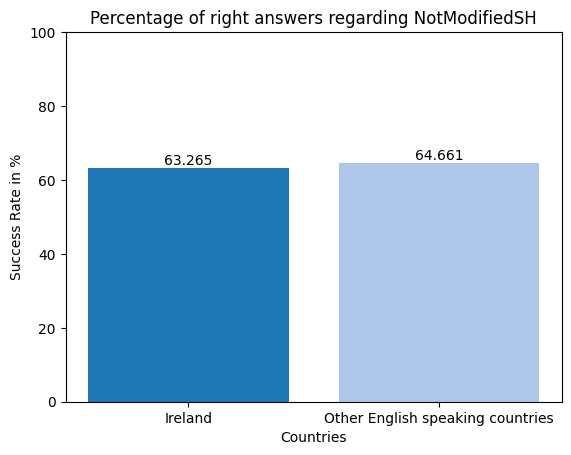

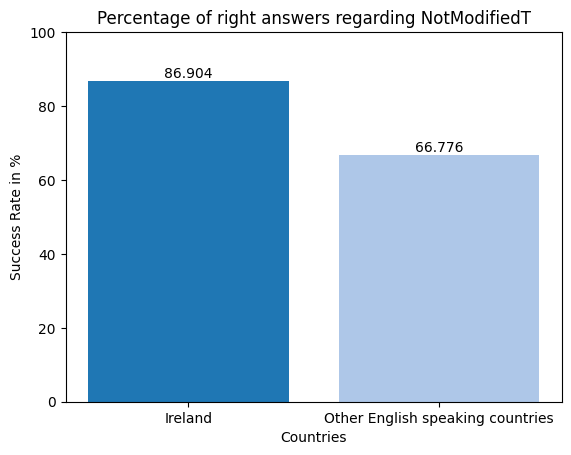

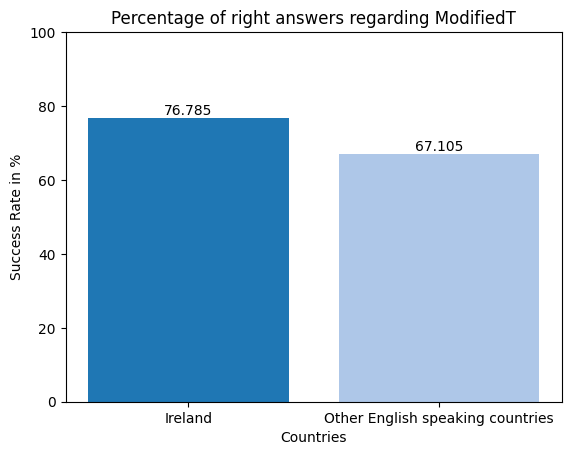

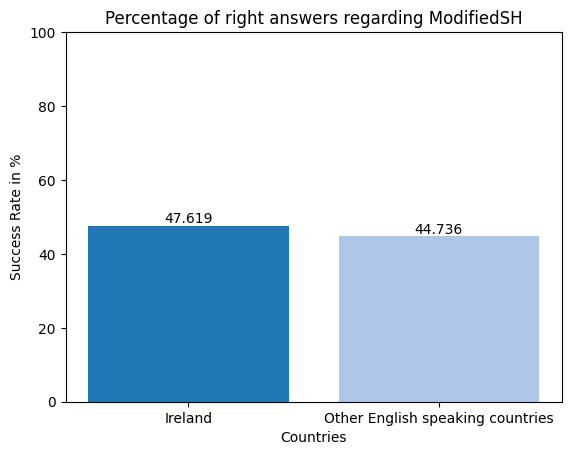

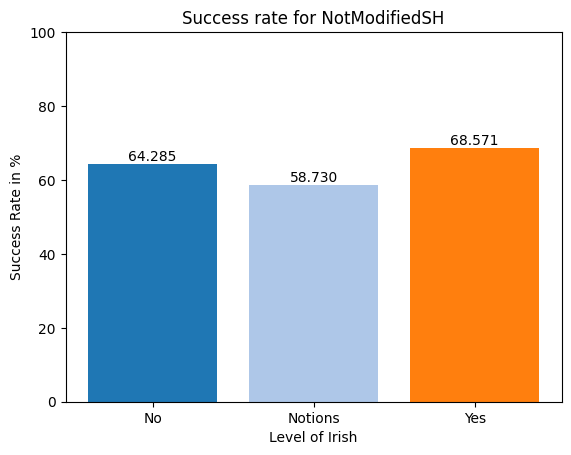

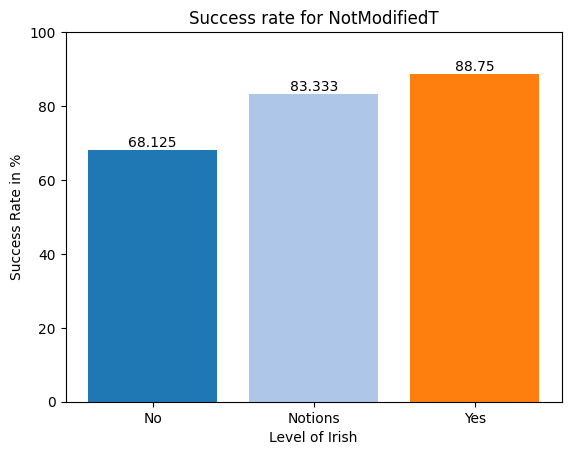

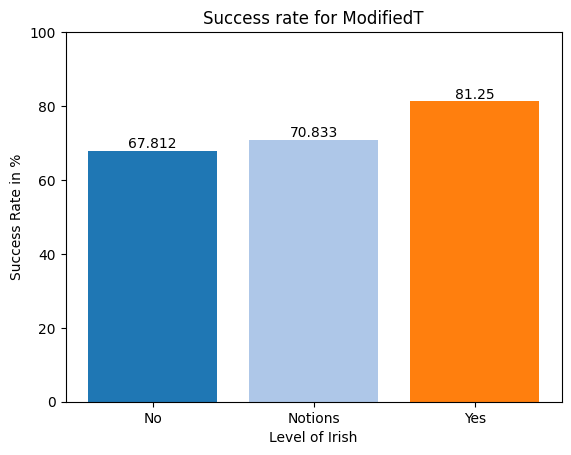

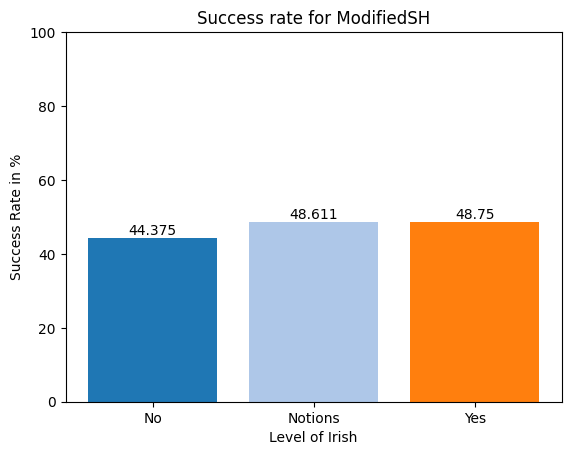

level of Irish yes vs no vs notions
---- Performing ANOVA test ----
Reject the null hypothesis. There is a significant difference between at least one pair of means.
F-statistic: 382.92974722271344
p-value: 2.1328535555947082e-156



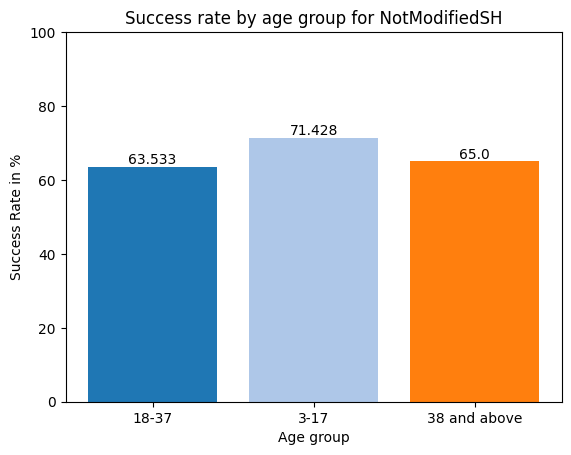

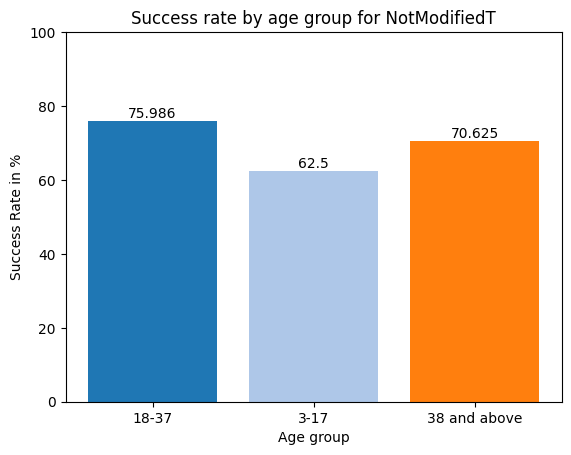

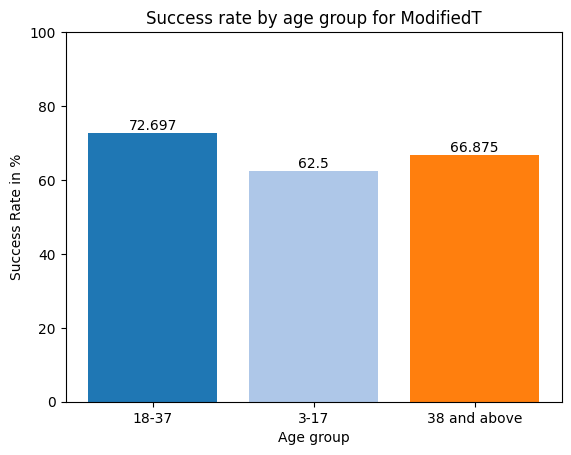

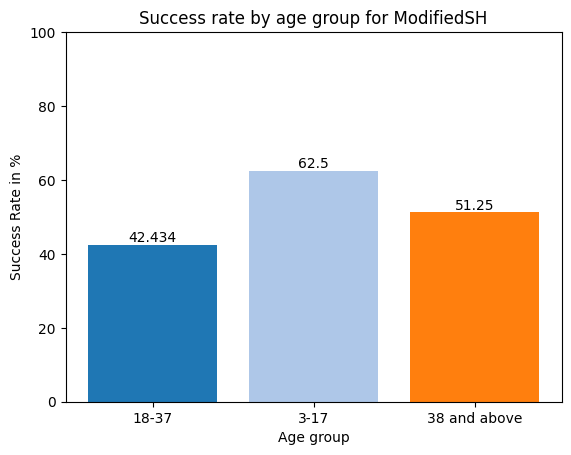

age1 vs age2 vs age3
---- Performing ANOVA test ----
Reject the null hypothesis. There is a significant difference between at least one pair of means.
F-statistic: 518.3247944002532
p-value: 6.601650218056088e-207



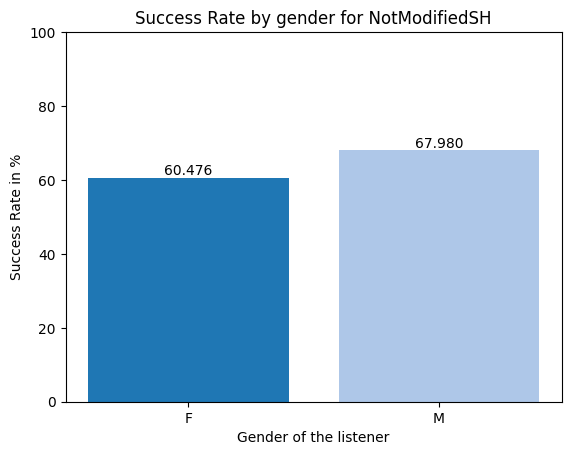

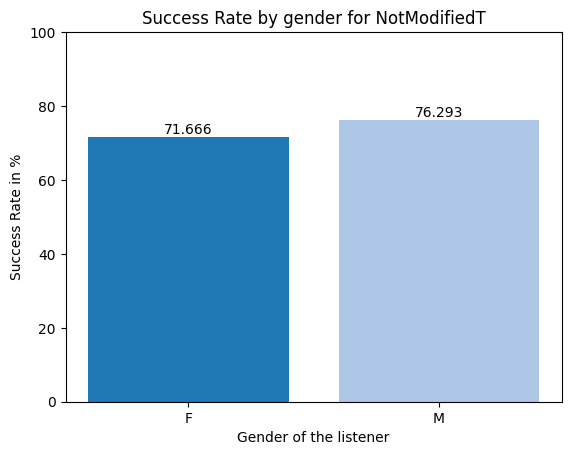

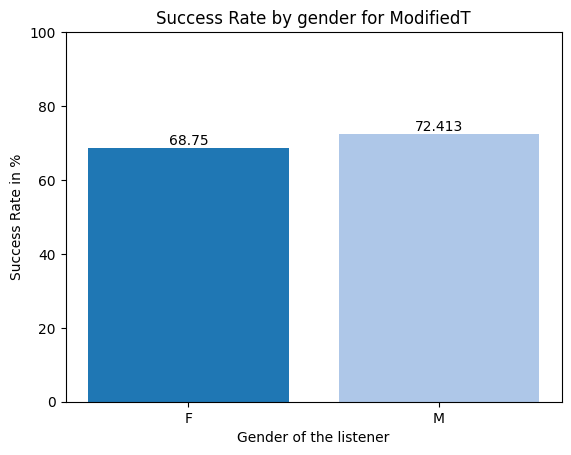

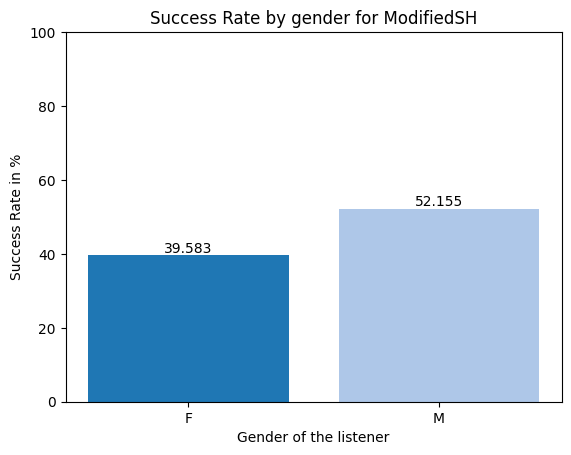

F vs M listeners
---- Performing Ttest ----
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
t-statistic: -1.5978723015097802
p-value: 0.11015781667686635



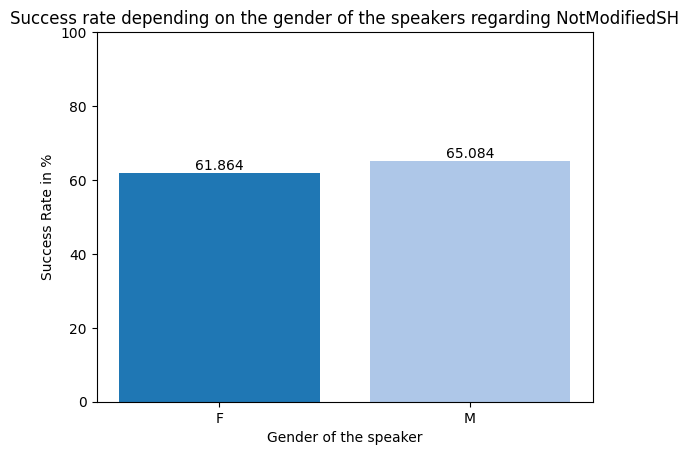

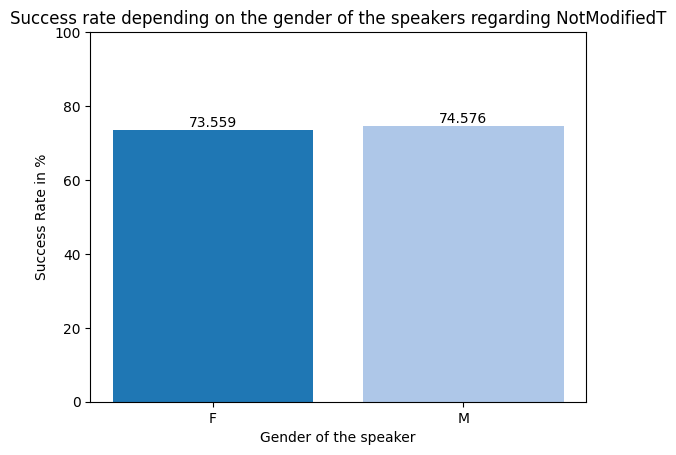

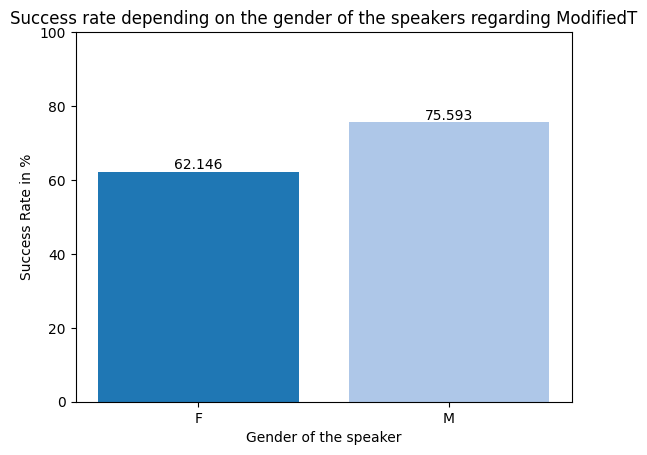

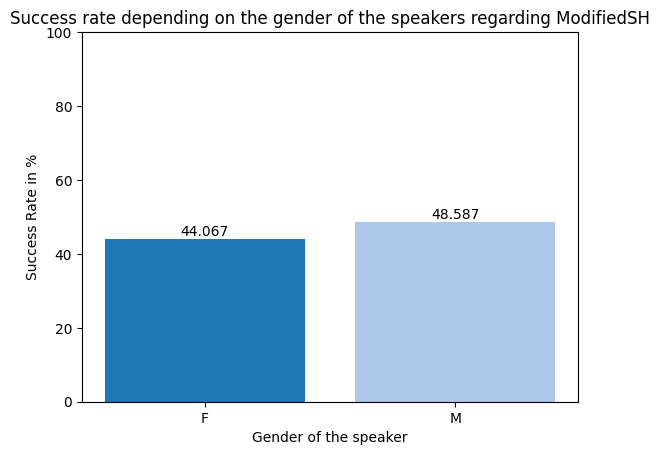

F vs M speakers
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -3.6627777218119673
p-value: 0.0002530294690264815



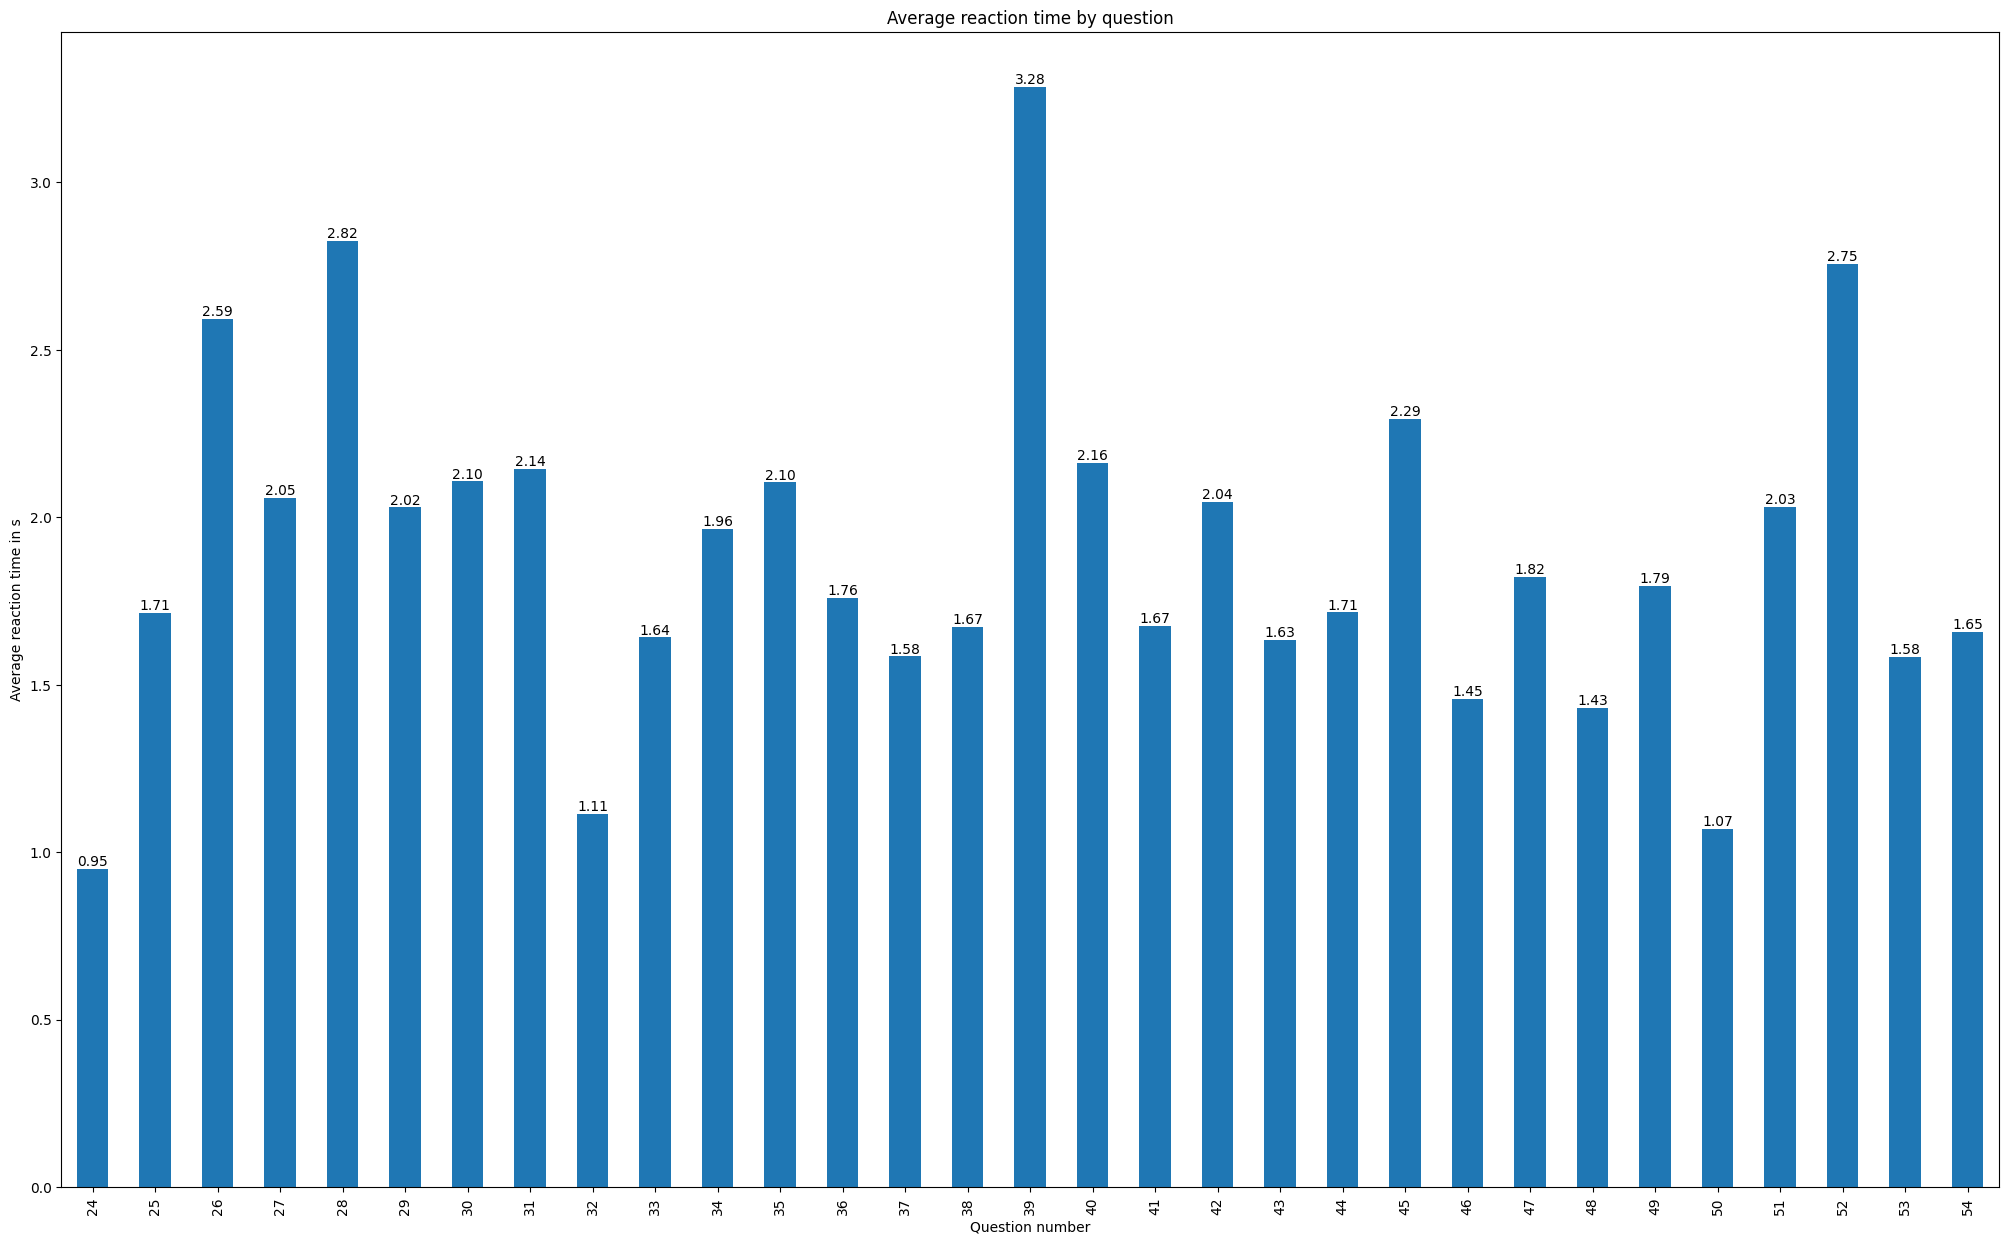

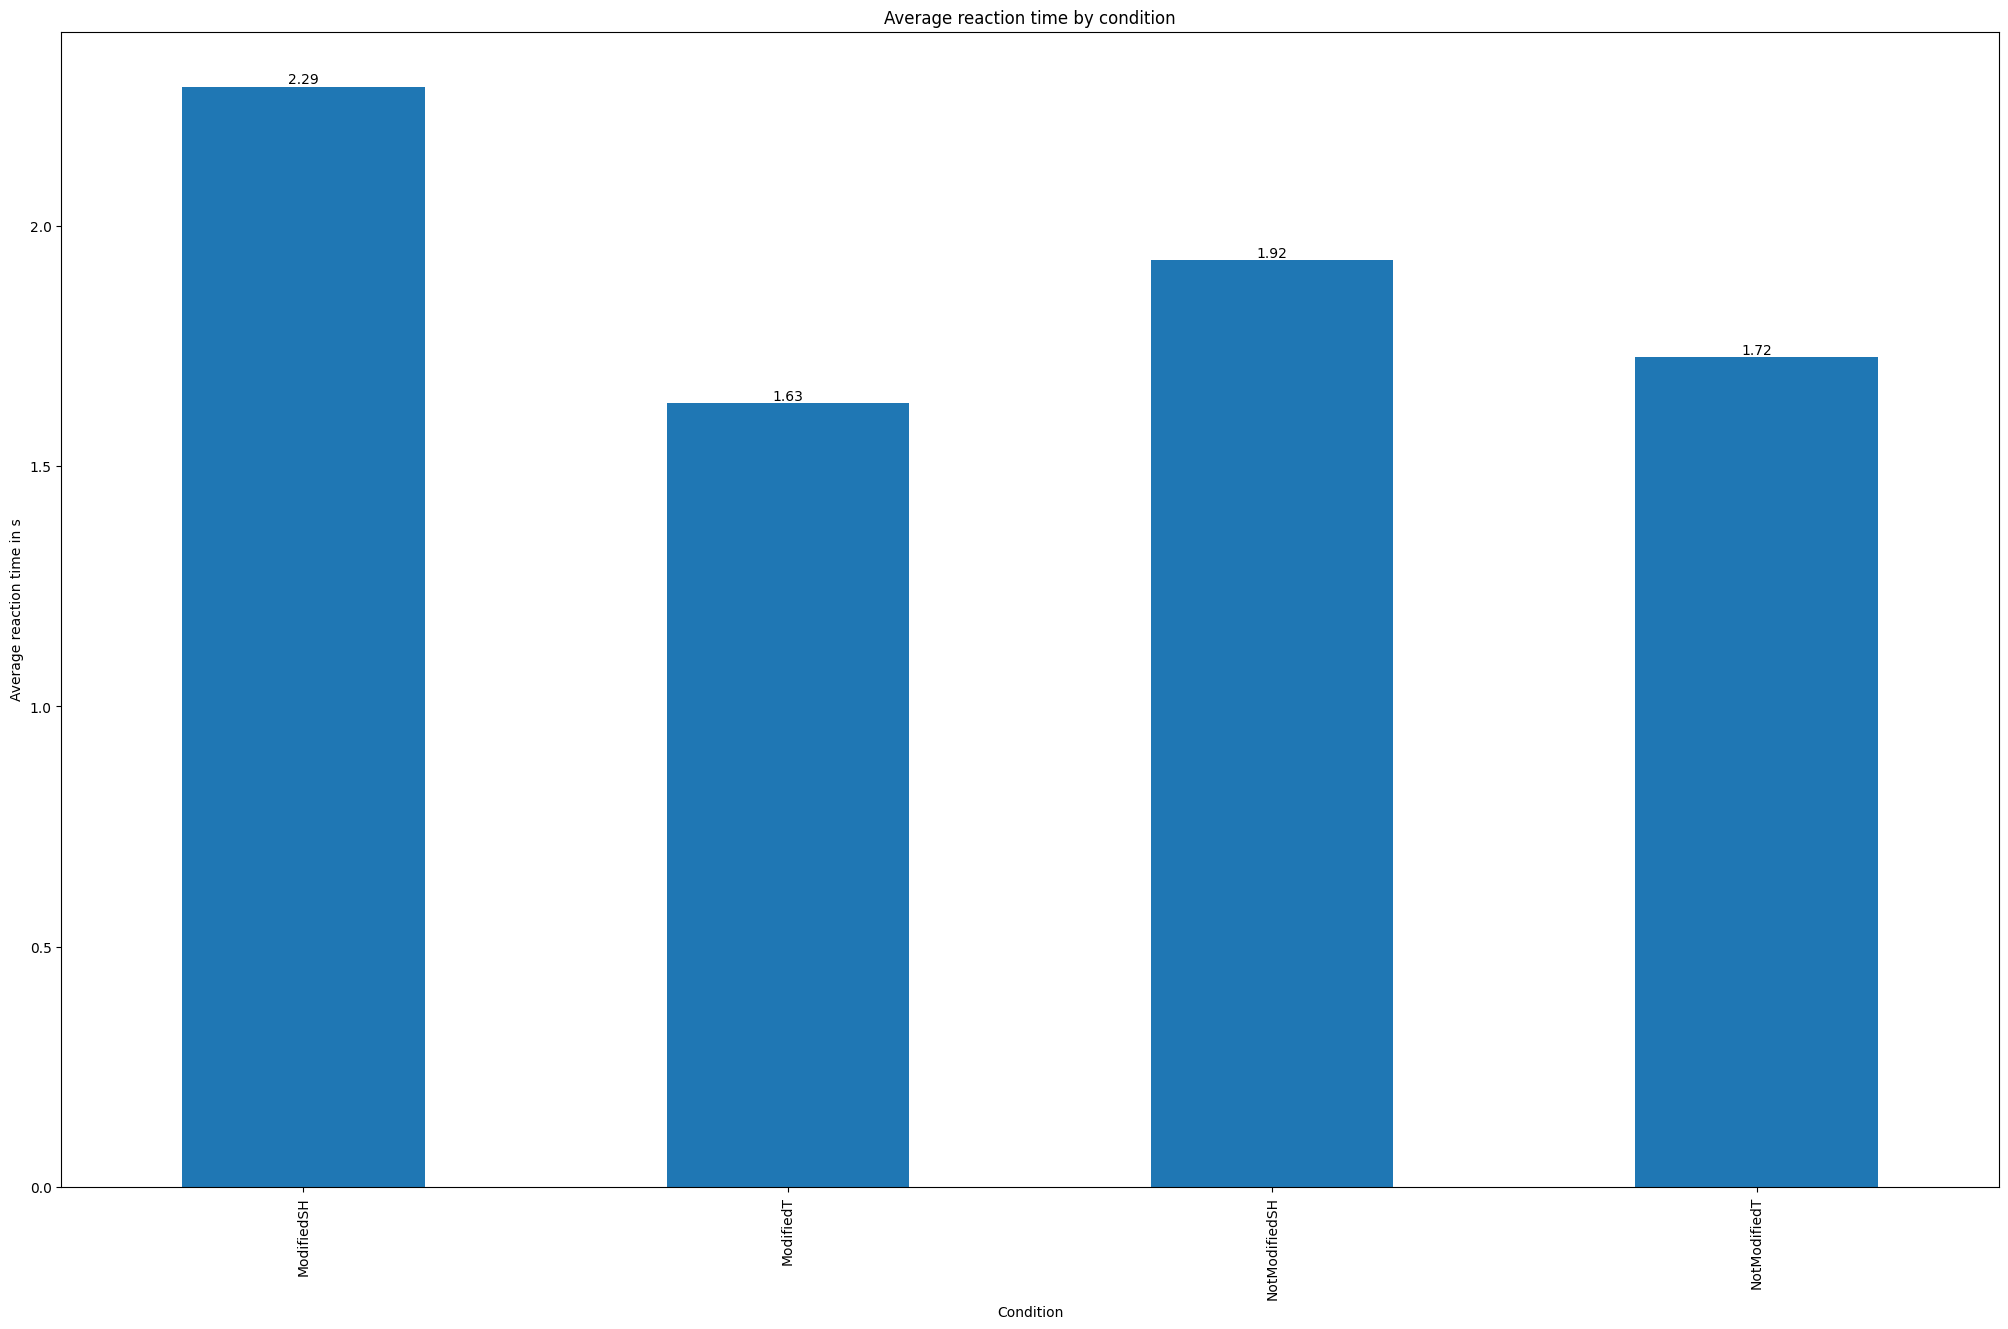

If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.
Pearson correlation coefficient between Success and Reaction time: -0.08839066041647936

Modified T
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -23.50286398260041
p-value: 9.00336706573124e-73

Modified SH
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -12.321452098603551
p-value: 5.176774851236724e-29

Not Modified T
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -33.290730350545445
p-value: 3.992997832617781e-108

Not Modified SH
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -15.85699985635506

In [5]:
# @title ALL PARTICIPANTS

# view beginning of the table
df_lex.head()

#----------------By COUNTRY------------------------------------------------------------------------------------------------------------------------------------------------------------

#go into list condition and take the value x
for x in condition:
    df = df_lex[df_lex['Condition'] == x]
    # plot_success_rate_by_country(df,x)
    plot_success_rate_by_parameter(df, x, 'Country_Categorized', 'Countries', 'Success Rate in %',  'Percentage of right answers regarding ')

#------------By LEVEL OF IRISH---------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = df_lex[df_lex['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Irish', 'Level of Irish', 'Success Rate in %',  'Success rate for ')

print('level of Irish yes vs no vs notions')
val1 = ((df_lex['Success'] == 1) & (df_lex['Irish'] == 'Yes'))
val2 = ((df_lex['Success'] == 1) & (df_lex['Irish'] == 'No'))
val3 = ((df_lex['Success'] == 1) & (df_lex['Irish'] == 'Notions'))

do_anova_test([val1, val2, val3])

#------------By AGE------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = df_lex[df_lex['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Age_group', 'Age group', 'Success Rate in %',  'Success rate by age group for ')

print('age1 vs age2 vs age3')

val1 = ((df_lex['Success'] == 1) & (df_lex['Age'] == 1))
val2 = ((df_lex['Success'] == 1) & (df_lex['Age'] == 2))
val3 = ((df_lex['Success'] == 1) & (df_lex['Age'] == 3))

do_anova_test([val1, val2, val3])

#-----------------By GENDER------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = df_lex[df_lex['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Gender', 'Gender of the listener', 'Success Rate in %',  'Success Rate by gender for ')

print('F vs M listeners')
val1 = ((df_lex['Success'] == 1) & (df_lex['Gender'] == 'F'))
val2 = ((df_lex['Success'] == 1) & (df_lex['Gender'] == 'M'))
do_ttest(val1, val2)

#------------By GENDER of the speaker------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = df_lex[df_lex['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Condition2', 'Gender of the speaker', 'Success Rate in %',  'Success rate depending on the gender of the speakers regarding ')

print('F vs M speakers')
val1 = ((df_lex['Success'] == 1) & (df_lex['Condition2'] == 'F'))
val2 = ((df_lex['Success'] == 1) & (df_lex['Condition2'] == 'M'))
do_ttest(val1, val2)

#------------Average reaction time in s By question---------------------------------------------------------------------------------------------------------------------------------------------------------

plot_bar_average_parameter(df_lex, 'ItemNb', 'Question number', 'Average reaction time in s', 'Average reaction time by question', 'Reaction time')

#------------Average reaction time in s By condition-----------------------------------------------------------------------------------------------------------------------------------

plot_bar_average_parameter(df_lex, 'Condition', 'Condition', 'Average reaction time in s', 'Average reaction time by condition', 'Reaction time')


# -----------------------------------------------------------------------Calculate Pearson correlation coefficient-----

correlation = df_lex['Success'].corr(df_lex['Reaction time'])

print("If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.")

print("Pearson correlation coefficient between Success and Reaction time:", correlation)

print("")


#---------------ANOVA IRISH vs OTHERS

All_filtered_df_lex_mod_t = df_mod_T.loc[df_mod_T['Country'].isin(['Ireland', 'Other English speaking countries'])]
All_filtered_df_lex_mod_sh = df_mod_SH.loc[df_mod_SH['Country'].isin(['Ireland', 'Other English speaking countries'])]
All_filtered_df_lex_not_mod_t = df_not_mod_T.loc[df_not_mod_T['Country'].isin(['Ireland', 'Other English speaking countries'])]
All_filtered_df_lex_not_mod_sh = df_not_mod_SH.loc[df_not_mod_SH['Country'].isin(['Ireland', 'Other English speaking countries'])]

print('Modified T')
val1 = ((All_filtered_df_lex_mod_t['Success'] == 1) & (All_filtered_df_lex_mod_t['Country'] == 'Other English speaking countries'))
val2 = ((All_filtered_df_lex_mod_t['Success'] == 1) & (All_filtered_df_lex_mod_t['Country'] == 'Ireland'))
do_ttest(val1, val2)

print('Modified SH')
val1 = ((All_filtered_df_lex_mod_sh['Success'] == 1) & (All_filtered_df_lex_mod_sh['Country'] == 'Other English speaking countries'))
val2 = ((All_filtered_df_lex_mod_sh['Success'] == 1) & (All_filtered_df_lex_mod_sh['Country'] == 'Ireland'))
do_ttest(val1, val2)

print('Not Modified T')
val1 = ((All_filtered_df_lex_not_mod_t['Success'] == 1) & (All_filtered_df_lex_not_mod_t['Country'] == 'Other English speaking countries'))
val2 = ((All_filtered_df_lex_not_mod_t['Success'] == 1) & (All_filtered_df_lex_not_mod_t['Country'] == 'Ireland'))
do_ttest(val1, val2)

print('Not Modified SH')
val1 = ((All_filtered_df_lex_not_mod_sh['Success'] == 1) & (All_filtered_df_lex_not_mod_sh['Country'] == 'Other English speaking countries'))
val2 = ((All_filtered_df_lex_not_mod_sh['Success'] == 1) & (All_filtered_df_lex_not_mod_sh['Country'] == 'Ireland'))
do_ttest(val1, val2)


[76.78571428571429, 47.61904761904762, 63.265306122448976, 86.9047619047619]


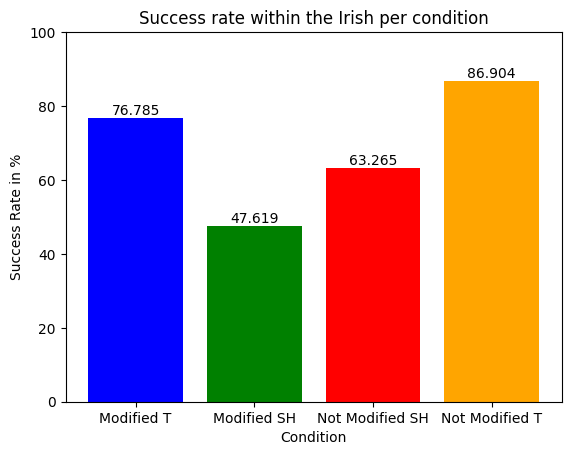

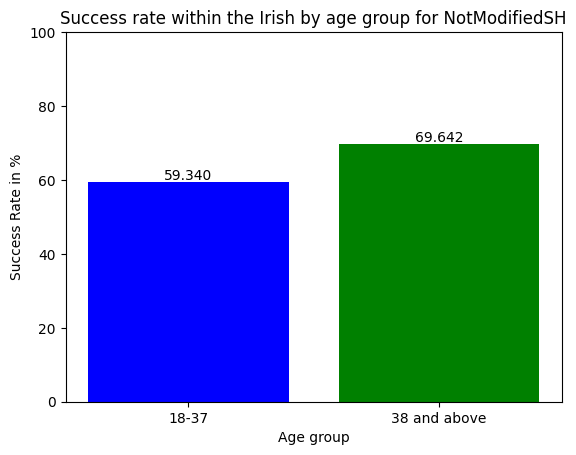

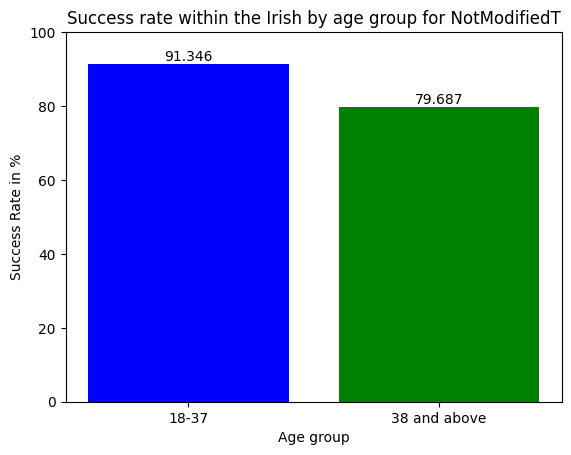

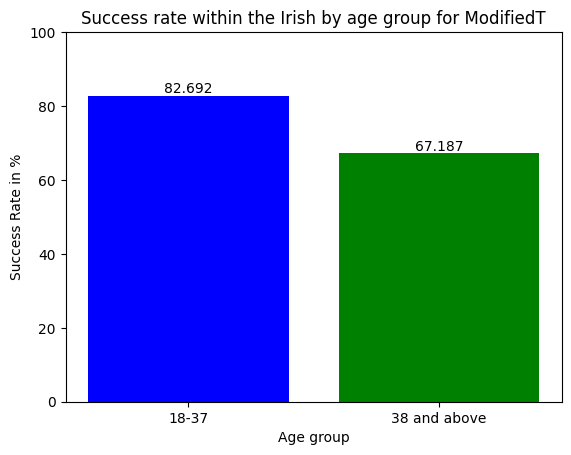

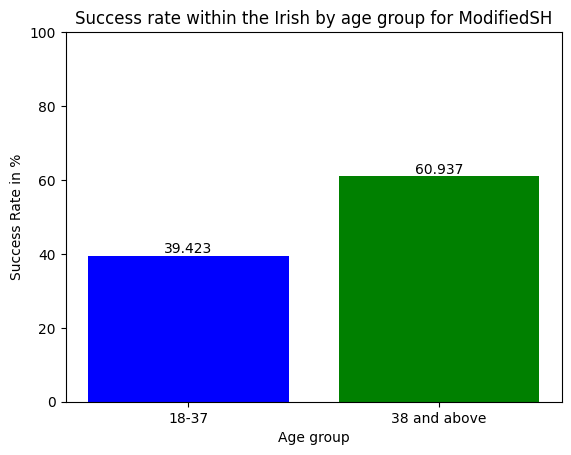

age2 vs age3
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: 6.149847410378703
p-value: 1.0303364960730197e-09



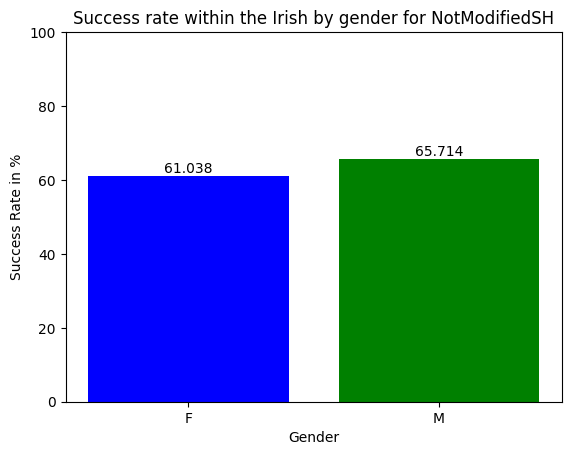

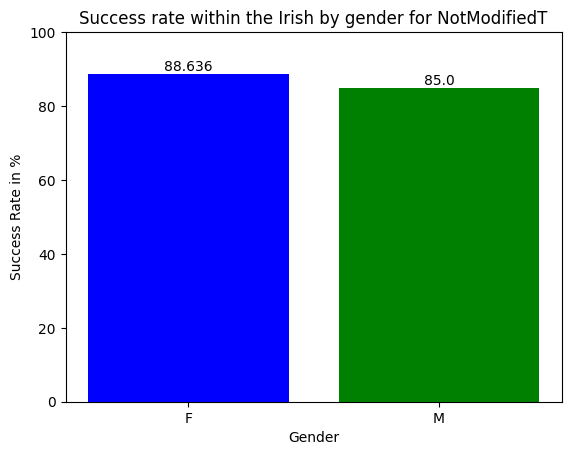

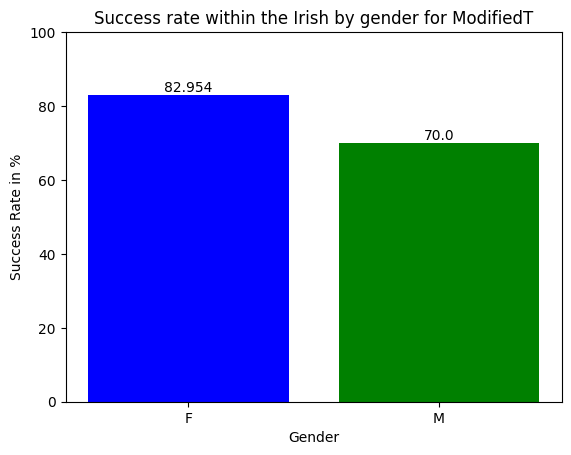

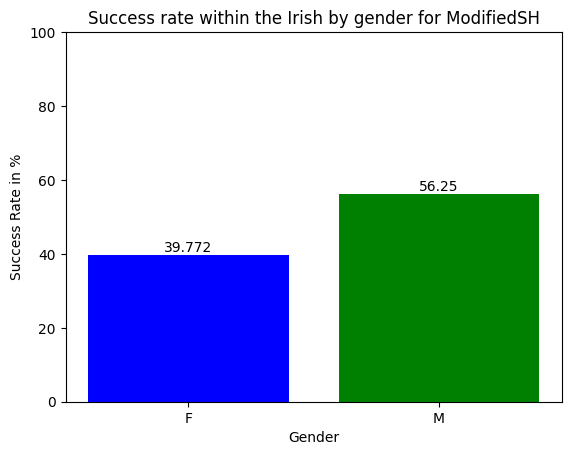

age2 vs age3
---- Performing Ttest ----
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
t-statistic: 1.0496879436554158
p-value: 0.2940567048755665



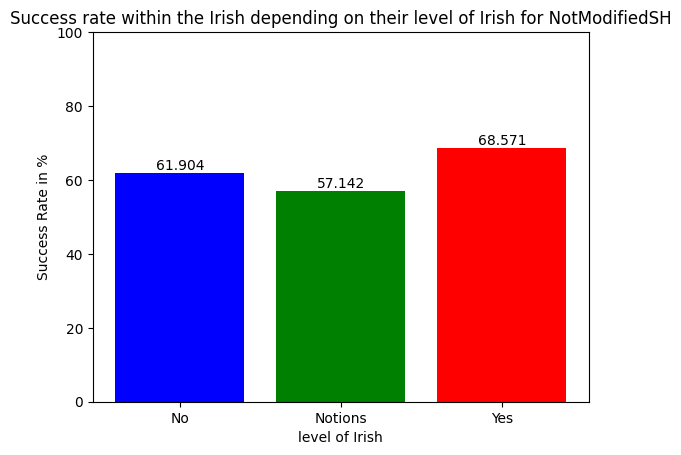

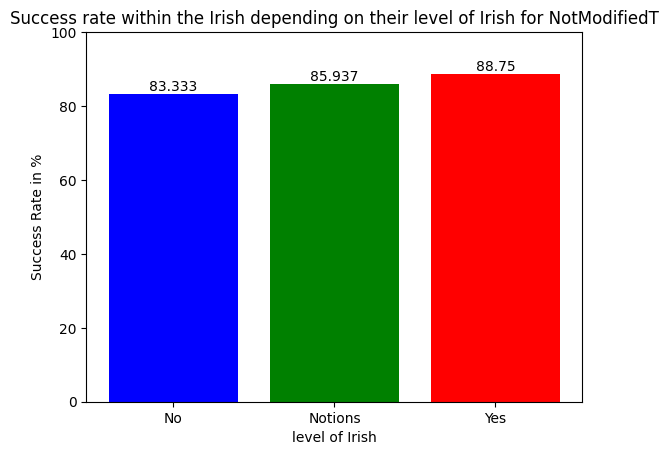

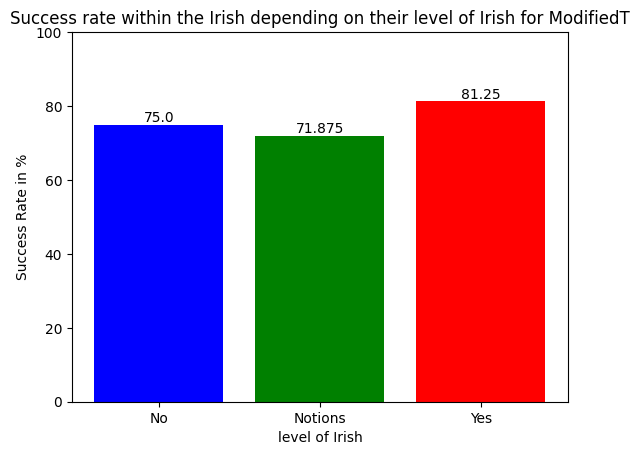

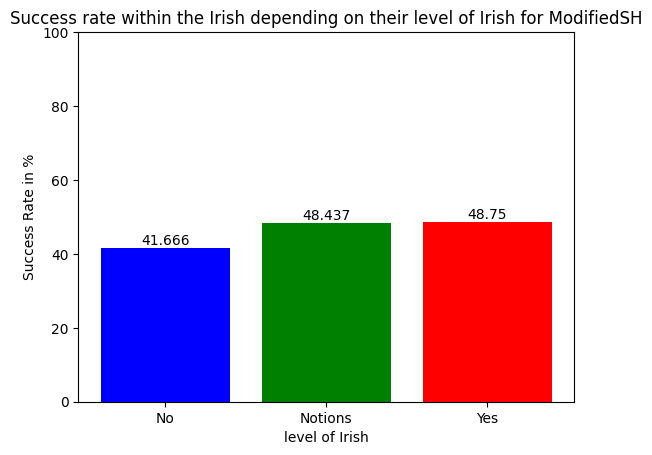

---- Performing ANOVA test ----
Reject the null hypothesis. There is a significant difference between at least one pair of means.
F-statistic: 62.037037037037045
p-value: 7.587344481872362e-27



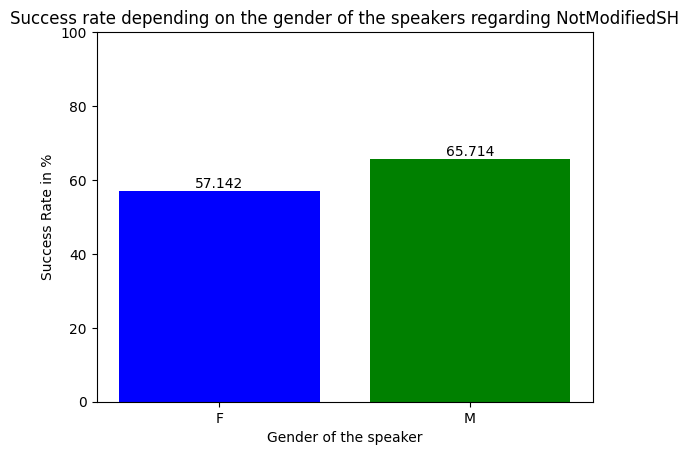

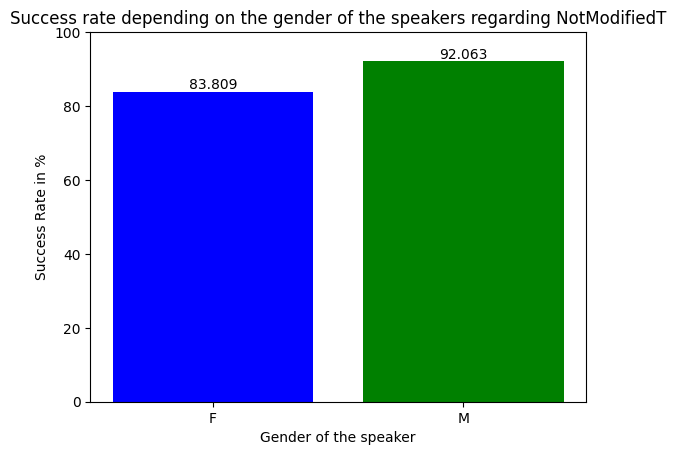

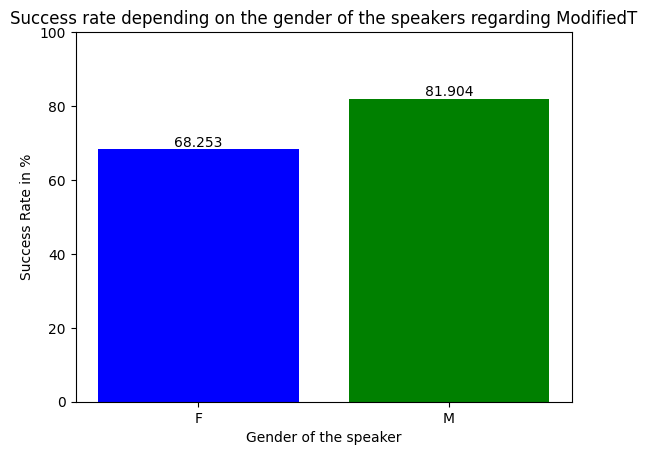

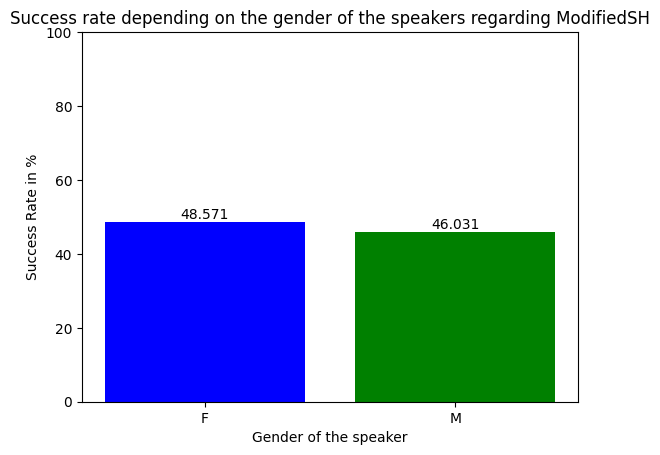

---- Performing ANOVA test ----
Reject the null hypothesis. There is a significant difference between at least one pair of means.
F-statistic: 4.418614409802356
p-value: 0.0357408588622416

age2 vs age3
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -2.10205004930957
p-value: 0.03574085886224103



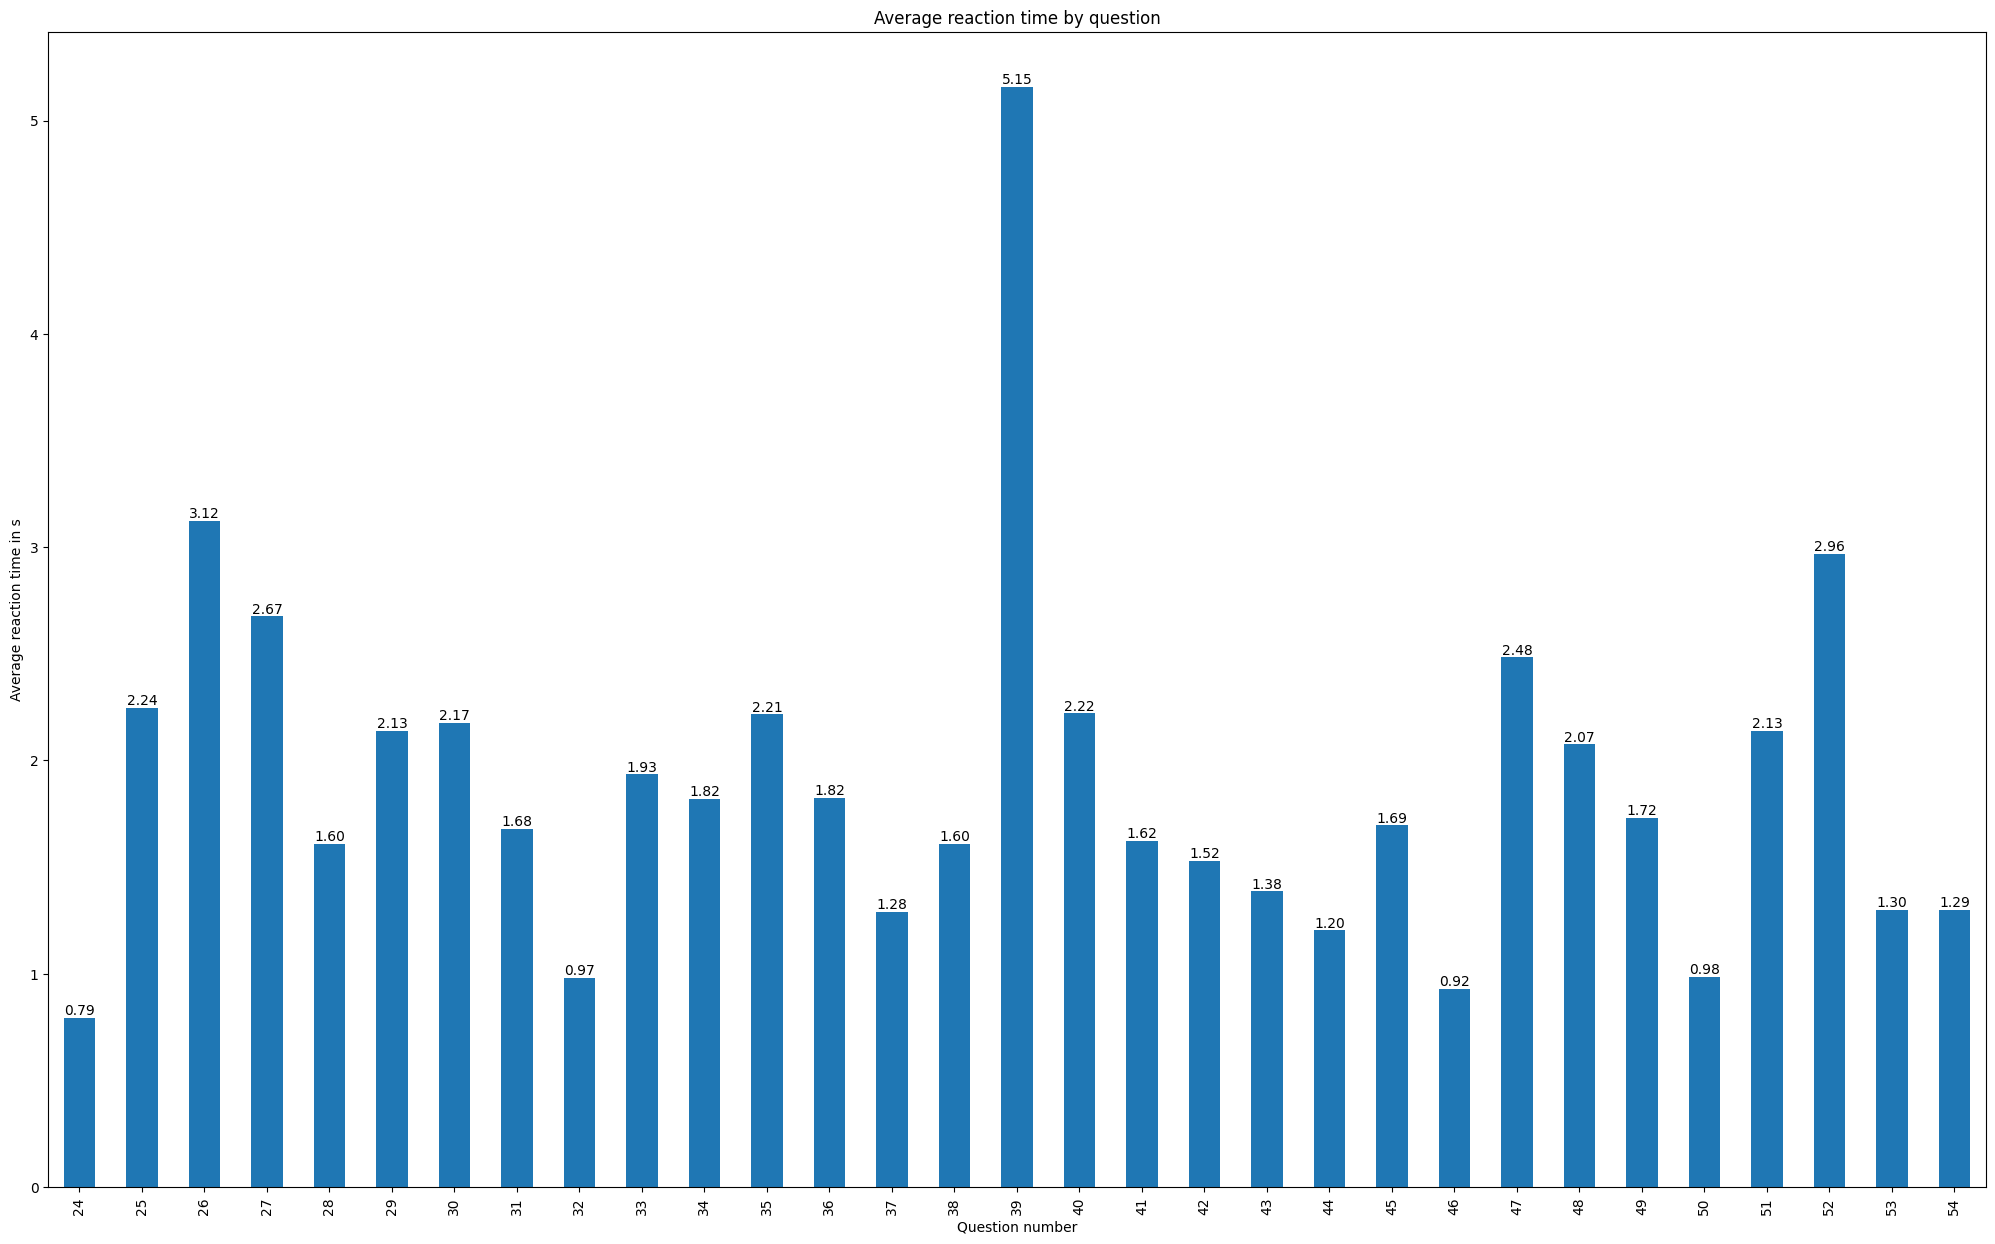

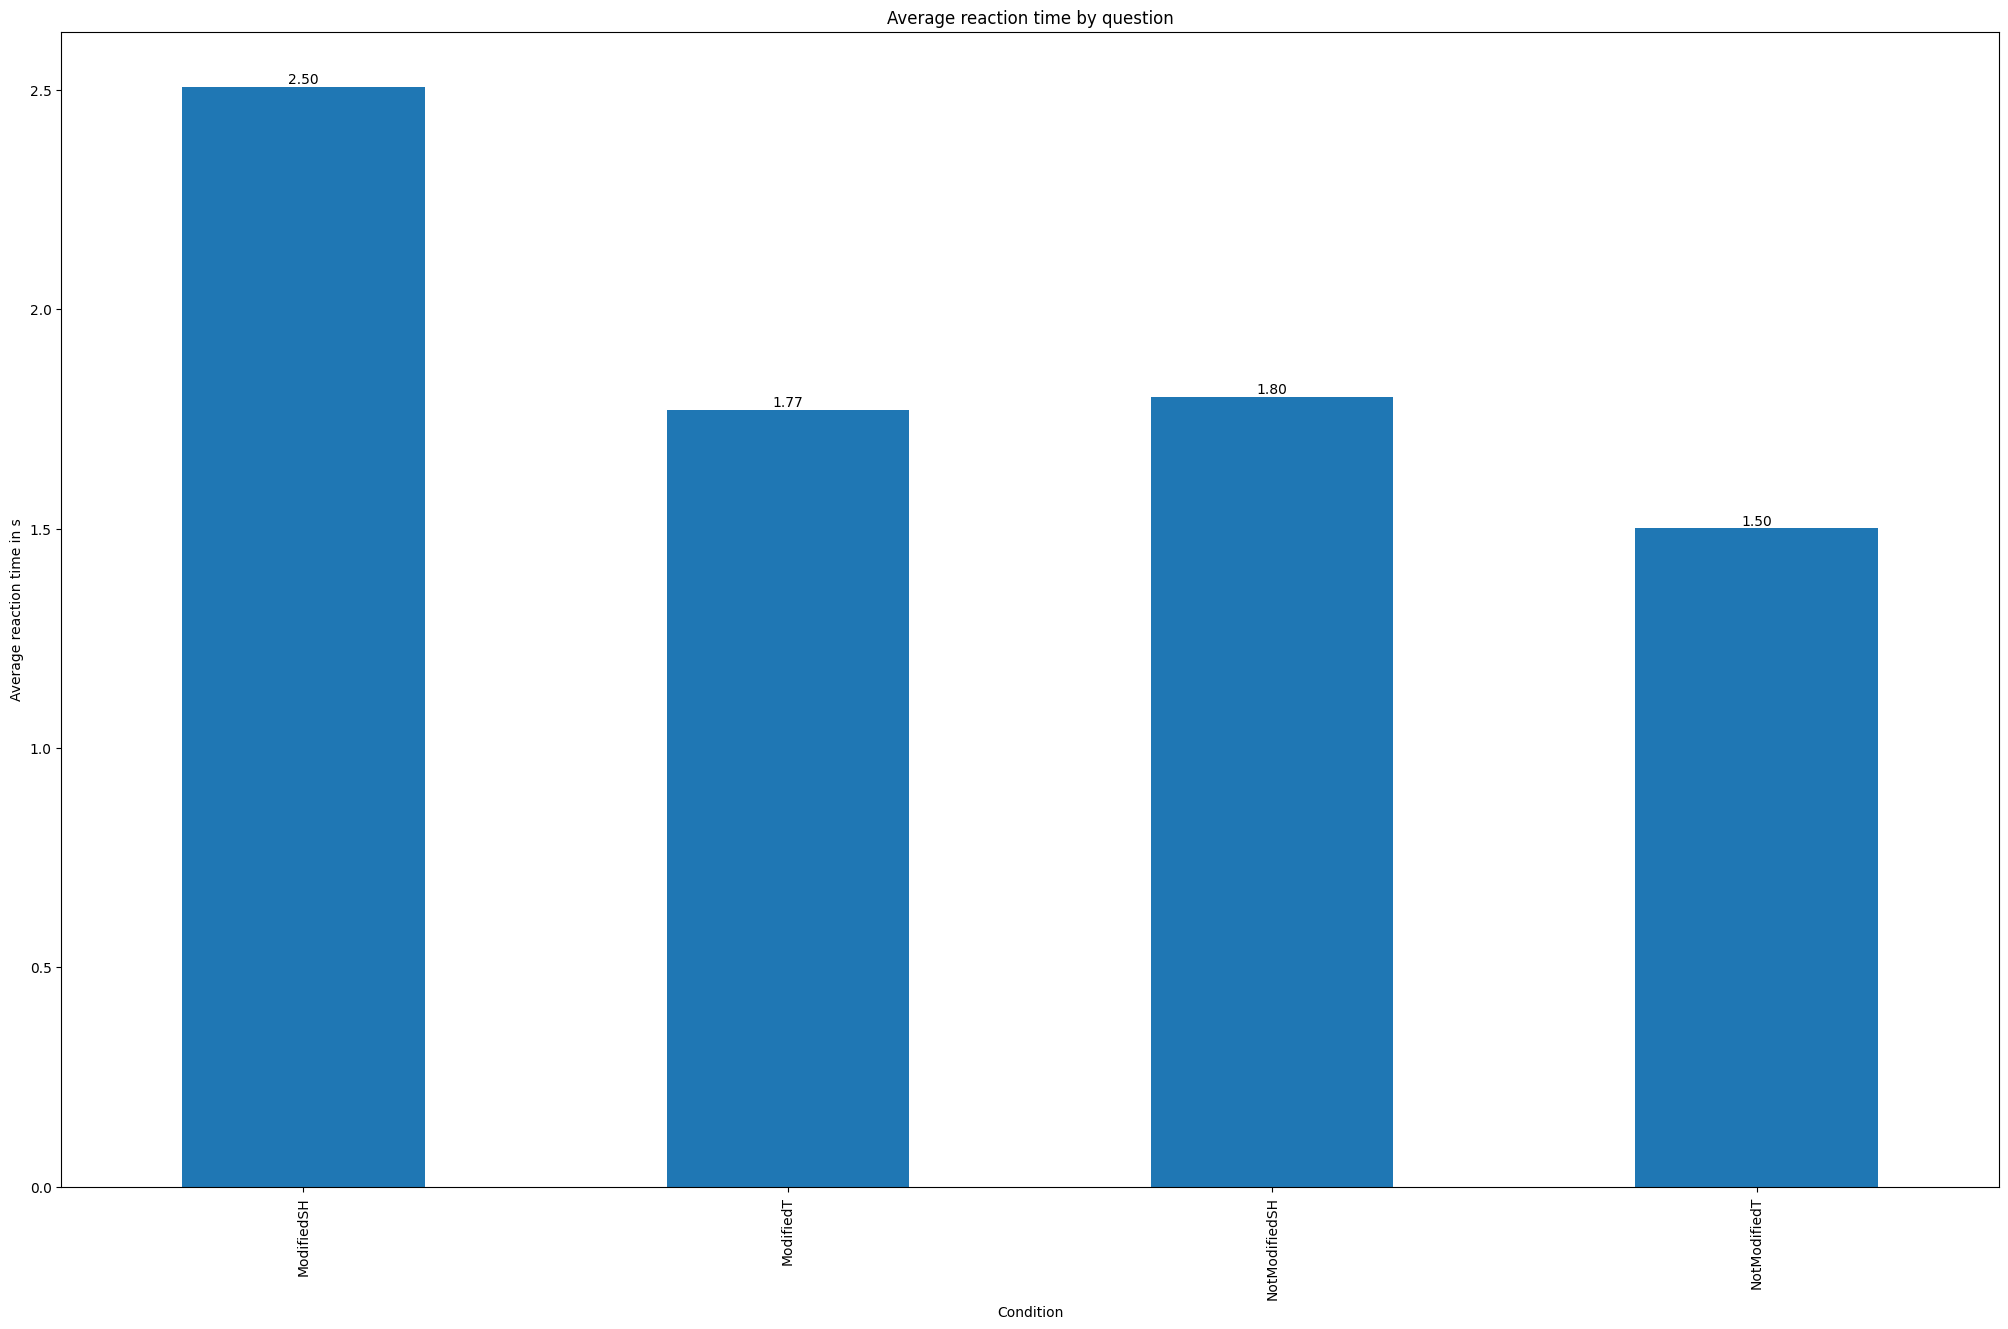

Modified SH vs Modified T
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: 5.763452133809732
p-value: 1.874361040170945e-08

If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.
Pearson correlation coefficient between Success and Reaction time: -0.08338942454805903



In [5]:
# @title WITHIN THE IRISH

#-------Per CONDITION
# Categorize 'Country' into 'Ireland'
filtered_df_lex_mod_t = df_mod_T.loc[df_mod_T['Country'] == 'Ireland']
filtered_df_lex_mod_sh = df_mod_SH.loc[df_mod_SH['Country'] == 'Ireland']
filtered_df_lex_not_mod_t = df_not_mod_T.loc[df_not_mod_T['Country'] == 'Ireland']
filtered_df_lex_not_mod_sh = df_not_mod_SH.loc[df_not_mod_SH['Country'] == 'Ireland']

# Calculate success rate for each condition in Ireland
success_ModifiedT = 100 * filtered_df_lex_mod_t[filtered_df_lex_mod_t['Success'] == 1].shape[0] / filtered_df_lex_mod_t.shape[0]
success_ModifiedSH = 100 * filtered_df_lex_mod_sh[filtered_df_lex_mod_sh['Success'] == 1].shape[0] / filtered_df_lex_mod_sh.shape[0]
success_NotModifiedT = 100 * filtered_df_lex_not_mod_t[filtered_df_lex_not_mod_t['Success'] == 1].shape[0] / filtered_df_lex_not_mod_t.shape[0]
success_NotModifiedSH = 100 * filtered_df_lex_not_mod_sh[filtered_df_lex_not_mod_sh['Success'] == 1].shape[0] / filtered_df_lex_not_mod_sh.shape[0]


headers = ['Modified T','Modified SH','Not Modified SH','Not Modified T']
datas = [success_ModifiedT, success_ModifiedSH, success_NotModifiedSH, success_NotModifiedT]

print(datas)

plot_2d_array(headers, datas, 'Condition', 'Success Rate in %', 'Success rate within the Irish per condition', colours=plot_colours80s)

#-------by AGE GROUP------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

filter_withinIrish = df_lex.loc[df_lex['Country'] == 'Ireland']
for x in condition:
    df = filter_withinIrish[filter_withinIrish['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Age_group', 'Age group', 'Success Rate in %',  'Success rate within the Irish by age group for ', colours=plot_colours80s)

print('age2 vs age3')
val1 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Age'] == 2))
val2 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Age'] == 3))
do_ttest(val1, val2)


#------by GENDER-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = filter_withinIrish[filter_withinIrish['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Gender', 'Gender', 'Success Rate in %',  'Success rate within the Irish by gender for ', colours=plot_colours80s)


print('age2 vs age3')
val1 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Gender'] == 'F'))
val2 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Gender'] == 'M'))
do_ttest(val1, val2)

#------by LEVEL OF IRISH------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = filter_withinIrish[filter_withinIrish['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Irish', 'level of Irish', 'Success Rate in %',  'Success rate within the Irish depending on their level of Irish for ', colours=plot_colours80s)

val1 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Irish'] == 'Yes'))
val2 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Irish'] == 'No'))
val3 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Irish'] == 'Notions'))

do_anova_test([val1, val2, val3])

#------by GENDER of the speaker------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = filter_withinIrish[filter_withinIrish['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Condition2', 'Gender of the speaker', 'Success Rate in %',  'Success rate depending on the gender of the speakers regarding ', colours=plot_colours80s)

val1 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Condition2'] == 'F'))
val2 = ((filter_withinIrish['Success'] == 1) & (filter_withinIrish['Condition2'] == 'M'))

do_anova_test([val1, val2])

print('age2 vs age3')
do_ttest(val1, val2)


#------------Average reaction time in s By ItemNb------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

plot_bar_average_parameter(filter_withinIrish, 'ItemNb', 'Question number', 'Average reaction time in s', 'Average reaction time by question', 'Reaction time')

#------------Average reaction time in s By condition------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

plot_bar_average_parameter(filter_withinIrish, 'Condition', 'Condition', 'Average reaction time in s', 'Average reaction time by question', 'Reaction time')

#-----------TTEST on 'Modified SH vs Modified T' ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print('Modified SH vs Modified T')
val1 = ((filtered_df_lex_mod_t['Success'] == 1))
val2 = ((filtered_df_lex_mod_sh['Success'] == 1))
do_ttest(val1, val2)


# Calculate Pearson correlation coefficient
correlation = filter_withinIrish['Success'].corr(filter_withinIrish['Reaction time'])

print("If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.")

print("Pearson correlation coefficient between Success and Reaction time:", correlation)

print("")




     Participant ItemNb ExpectedKey Condition2  Condition  \
37        Adrien     48           r          M  ModifiedT   
38        Adrien     47           r          M  ModifiedT   
44        Adrien     41           r          F  ModifiedT   
47        Adrien     38           r          M  ModifiedT   
48        Adrien     37           r          F  ModifiedT   
...          ...    ...         ...        ...        ...   
1808       66543     41           r          F  ModifiedT   
1810       66543     48           r          M  ModifiedT   
1812       66543     37           r          F  ModifiedT   
1814       66543     47           r          M  ModifiedT   
1817       66543     38           r          M  ModifiedT   

     key_resp_question3.keys  Reaction time Gender  Age           Country  \
37                         e       4.119446      M    3  Northern Ireland   
38                         e       0.613385      M    3  Northern Ireland   
44                         e       1

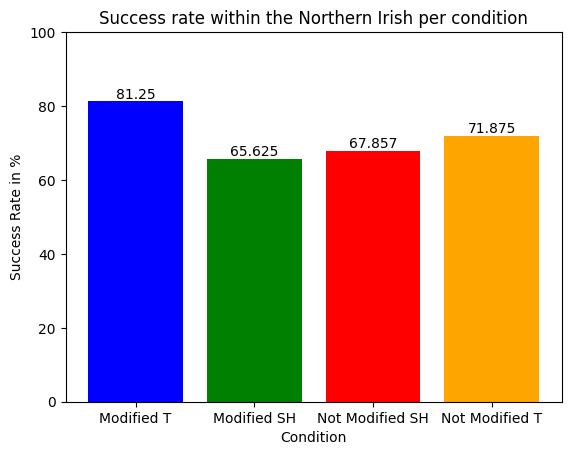

[76.78571428571429, 47.61904761904762, 63.265306122448976, 86.9047619047619]


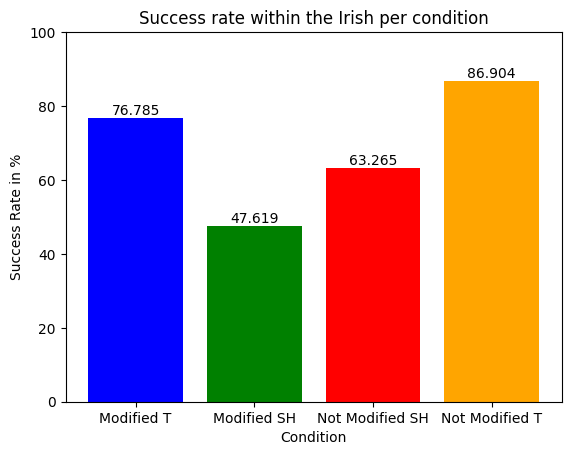

[76.78571428571429, 81.25, 47.61904761904762, 65.625, 63.265306122448976, 67.85714285714286, 86.9047619047619, 71.875]


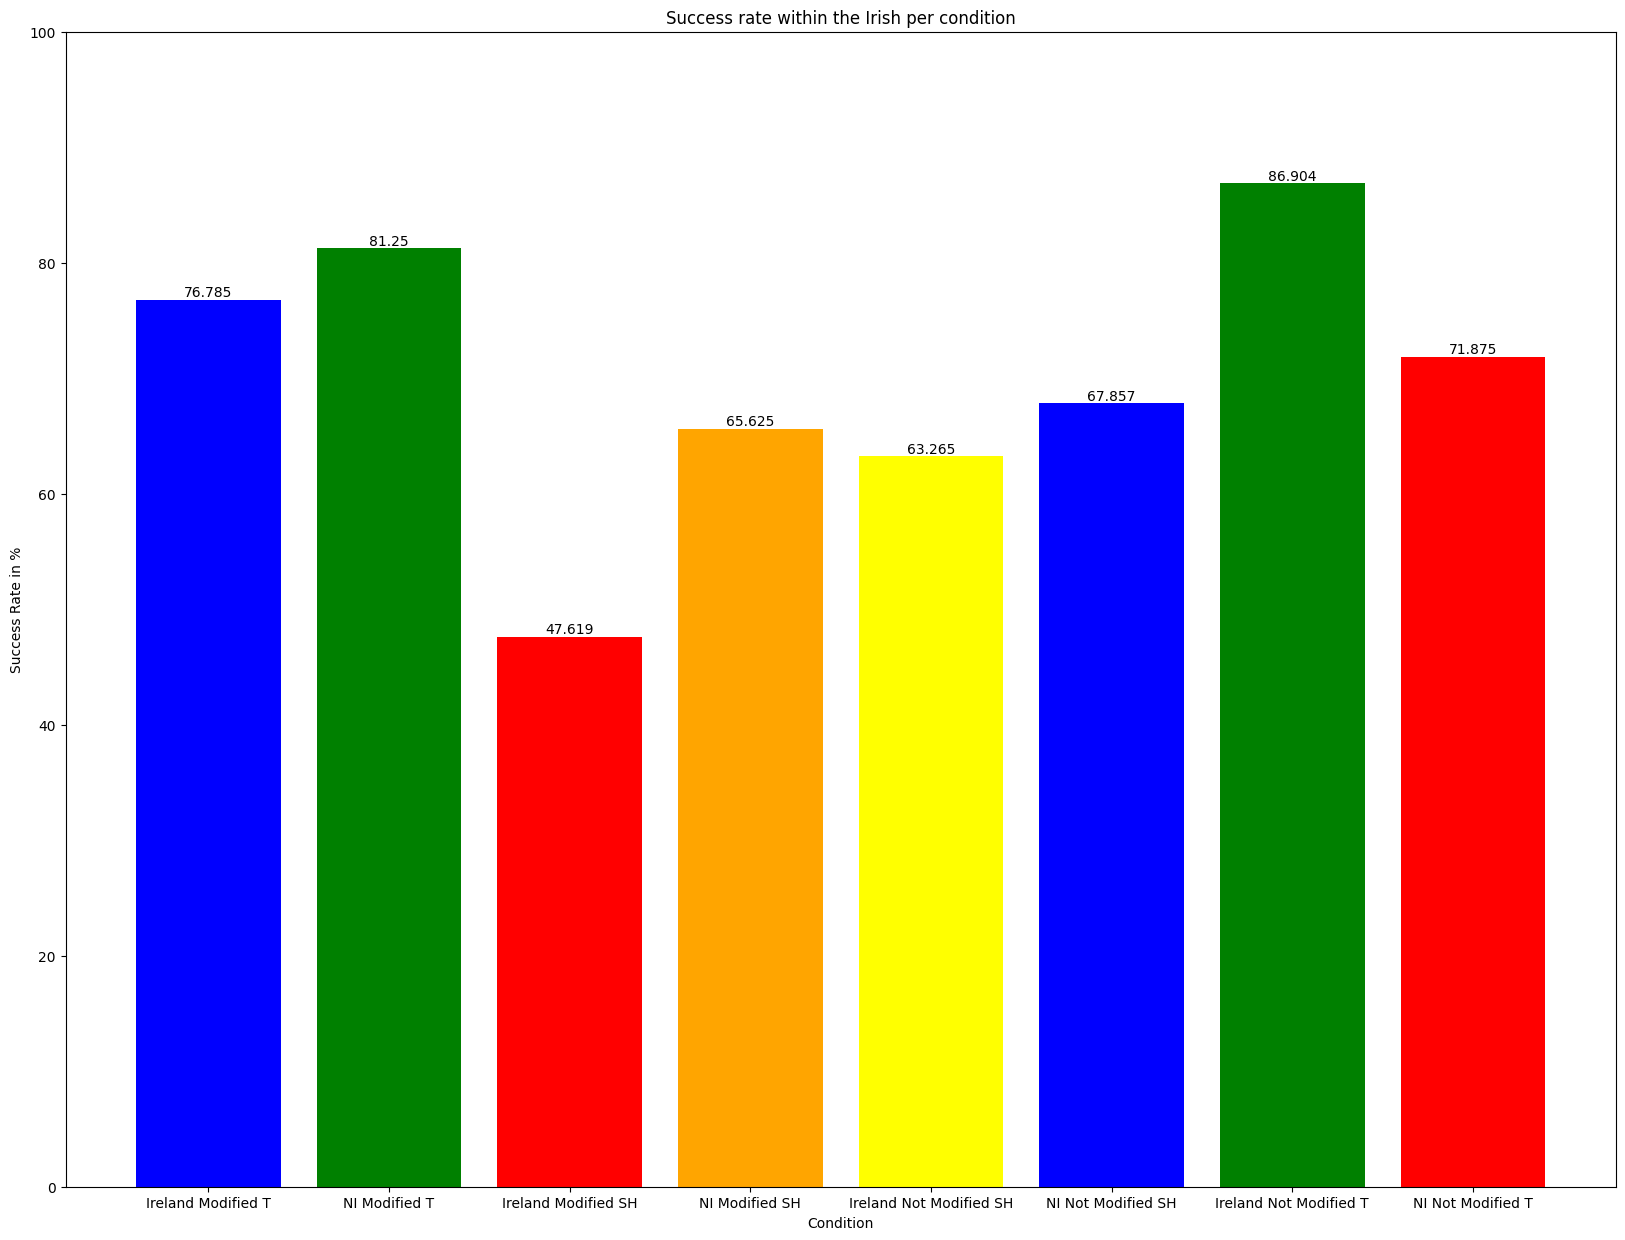

Modified T
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -12.421472992486713
p-value: 3.6381008841052305e-30

Modified SH
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -7.2009795060287445
p-value: 3.0086130252051894e-12

Not Modified T
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -15.86926671582109
p-value: 2.722500786375387e-44

Not Modified SH
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -9.485459276021054
p-value: 3.9139911326838484e-19



In [6]:
# @title Ireland VS NI

#-------Per CONDITION
# Categorise 'Country' into ('Ireland', 'Northern Ireland')
filtered_df_lex_mod_t = df_mod_T.loc[df_mod_T['Country'].isin(['Ireland', 'Northern Ireland'])]
filtered_df_lex_mod_sh = df_mod_SH.loc[df_mod_SH['Country'].isin(['Ireland', 'Northern Ireland'])]
filtered_df_lex_not_mod_t = df_not_mod_T.loc[df_not_mod_T['Country'].isin(['Ireland', 'Northern Ireland'])]
filtered_df_lex_not_mod_sh = df_not_mod_SH.loc[df_not_mod_SH['Country'].isin(['Ireland', 'Northern Ireland'])]

print(filtered_df_lex_mod_t)

# Calculate success rate for each condition in NI
success_ModifiedT_NI = (100 * filtered_df_lex_mod_t[(filtered_df_lex_mod_t['Success'] == 1) & (filtered_df_lex_mod_t['Country'] == 'Northern Ireland')].shape[0]
                        / filtered_df_lex_mod_t[filtered_df_lex_mod_t['Country'] == 'Northern Ireland'].shape[0])

success_ModifiedSH_NI = (100 * filtered_df_lex_mod_sh[(filtered_df_lex_mod_sh['Success'] == 1) & (filtered_df_lex_mod_sh['Country'] == 'Northern Ireland')].shape[0]
                         / filtered_df_lex_mod_sh[filtered_df_lex_mod_sh['Country'] == 'Northern Ireland'].shape[0])

success_NotModifiedT_NI = (100 * filtered_df_lex_not_mod_t[(filtered_df_lex_not_mod_t['Success'] == 1) & (filtered_df_lex_not_mod_t['Country'] == 'Northern Ireland')].shape[0]
                           / filtered_df_lex_not_mod_t[filtered_df_lex_not_mod_t['Country'] == 'Northern Ireland'].shape[0])

success_NotModifiedSH_NI = (100 * filtered_df_lex_not_mod_sh[(filtered_df_lex_not_mod_sh['Success'] == 1) & (filtered_df_lex_not_mod_sh['Country'] == 'Northern Ireland')].shape[0]
                            / filtered_df_lex_not_mod_sh[filtered_df_lex_not_mod_sh['Country'] == 'Northern Ireland'].shape[0])

headers = ['Modified T','Modified SH','Not Modified SH','Not Modified T']
datas = [success_ModifiedT_NI, success_ModifiedSH_NI, success_NotModifiedSH_NI, success_NotModifiedT_NI]

print(datas)

plot_2d_array(headers, datas, 'Condition', 'Success Rate in %', 'Success rate within the Northern Irish per condition', colours=plot_colours80s)

# Calculate success rate for each condition in Ireland
success_ModifiedT = (100 * filtered_df_lex_mod_t[(filtered_df_lex_mod_t['Success'] == 1) & (filtered_df_lex_mod_t['Country'] == 'Ireland')].shape[0]
                     / filtered_df_lex_mod_t[filtered_df_lex_mod_t['Country'] == 'Ireland'].shape[0])
success_ModifiedSH = (100 * filtered_df_lex_mod_sh[(filtered_df_lex_mod_sh['Success'] == 1) & (filtered_df_lex_mod_sh['Country'] == 'Ireland')].shape[0]
                      / filtered_df_lex_mod_sh[filtered_df_lex_mod_sh['Country'] == 'Ireland'].shape[0])
success_NotModifiedT = (100 * filtered_df_lex_not_mod_t[(filtered_df_lex_not_mod_t['Success'] == 1) & (filtered_df_lex_not_mod_t['Country'] == 'Ireland')].shape[0]
                        / filtered_df_lex_not_mod_t[filtered_df_lex_not_mod_t['Country'] == 'Ireland'].shape[0])
success_NotModifiedSH = (100 * filtered_df_lex_not_mod_sh[(filtered_df_lex_not_mod_sh['Success'] == 1) & (filtered_df_lex_not_mod_sh['Country'] == 'Ireland')].shape[0]
                         / filtered_df_lex_not_mod_sh[filtered_df_lex_not_mod_sh['Country'] == 'Ireland'].shape[0])

headers = ['Modified T','Modified SH','Not Modified SH','Not Modified T']
datas = [success_ModifiedT, success_ModifiedSH, success_NotModifiedSH, success_NotModifiedT]

print(datas)

plot_2d_array(headers, datas, 'Condition', 'Success Rate in %', 'Success rate within the Irish per condition', colours=plot_colours80s)


headers = ['Ireland Modified T', 'NI Modified T', 'Ireland Modified SH', 'NI Modified SH', 'Ireland Not Modified SH', 'NI Not Modified SH', 'Ireland Not Modified T', 'NI Not Modified T']
datas = [success_ModifiedT, success_ModifiedT_NI, success_ModifiedSH, success_ModifiedSH_NI, success_NotModifiedSH, success_NotModifiedSH_NI, success_NotModifiedT, success_NotModifiedT_NI]

print(datas)

plot_2d_array(headers, datas, 'Condition', 'Success Rate in %', 'Success rate within the Irish per condition', colours=plot_colours80s, fig_size=(20, 15))

print('Modified T')
val1 = ((filtered_df_lex_mod_t['Success'] == 1) & (filtered_df_lex_mod_t['Country'] == 'Northern Ireland'))
val2 = ((filtered_df_lex_mod_t['Success'] == 1) & (filtered_df_lex_mod_t['Country'] == 'Ireland'))
do_ttest(val1, val2)

print('Modified SH')
val1 = ((filtered_df_lex_mod_sh['Success'] == 1) & (filtered_df_lex_mod_sh['Country'] == 'Northern Ireland'))
val2 = ((filtered_df_lex_mod_sh['Success'] == 1) & (filtered_df_lex_mod_sh['Country'] == 'Ireland'))
do_ttest(val1, val2)

print('Not Modified T')
val1 = ((filtered_df_lex_not_mod_t['Success'] == 1) & (filtered_df_lex_not_mod_t['Country'] == 'Northern Ireland'))
val2 = ((filtered_df_lex_not_mod_t['Success'] == 1) & (filtered_df_lex_not_mod_t['Country'] == 'Ireland'))
do_ttest(val1, val2)

print('Not Modified SH')
val1 = ((filtered_df_lex_not_mod_sh['Success'] == 1) & (filtered_df_lex_not_mod_sh['Country'] == 'Northern Ireland'))
val2 = ((filtered_df_lex_not_mod_sh['Success'] == 1) & (filtered_df_lex_not_mod_sh['Country'] == 'Ireland'))
do_ttest(val1, val2)


[67.10526315789474, 44.73684210526316, 64.66165413533835, 66.77631578947368]


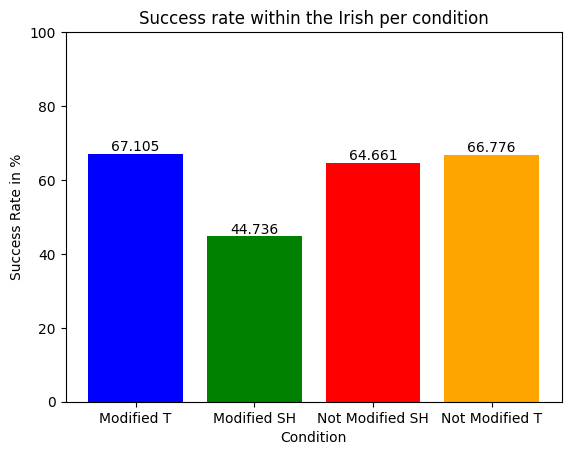

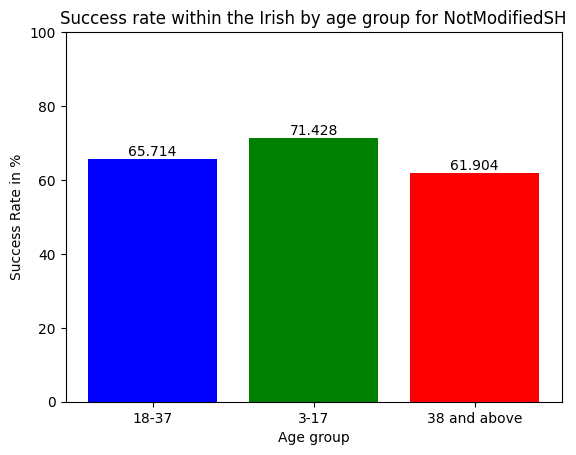

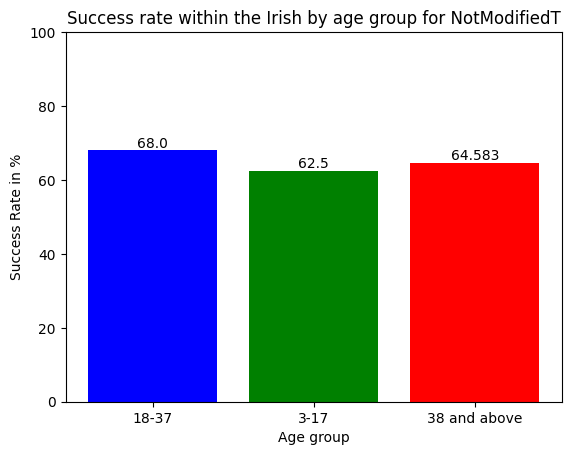

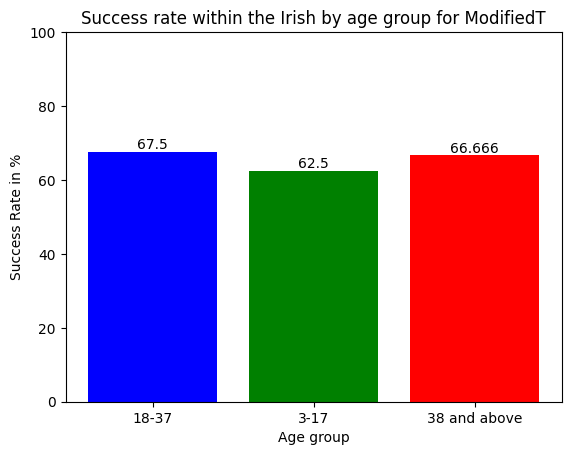

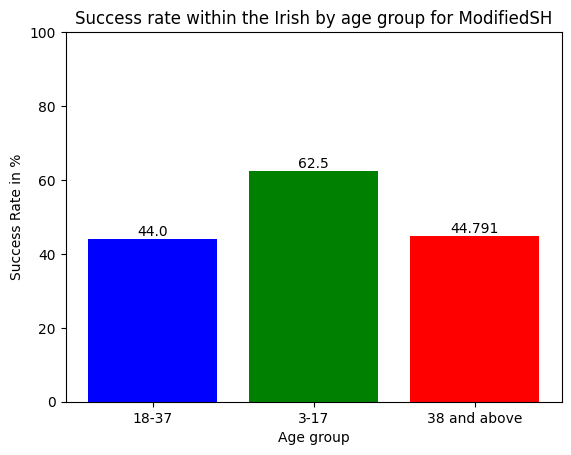

age1 vs age2 vs age3
---- Performing ANOVA test ----
Reject the null hypothesis. There is a significant difference between at least one pair of means.
F-statistic: 321.5335381356306
p-value: 5.197059000585793e-129



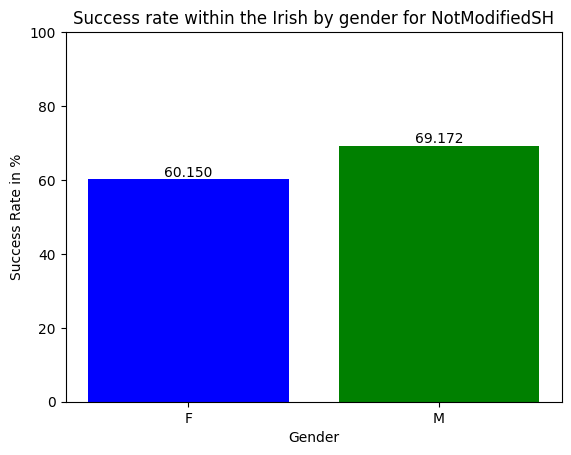

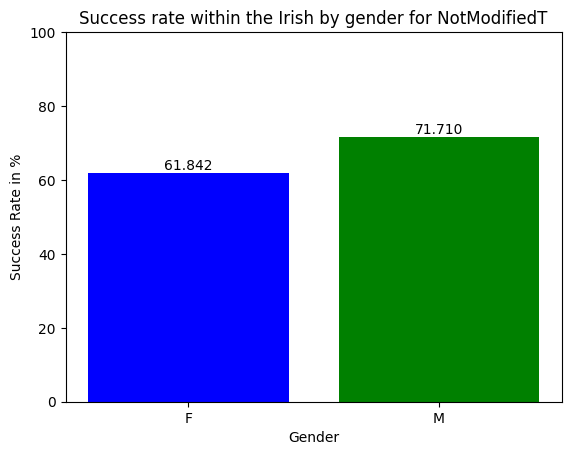

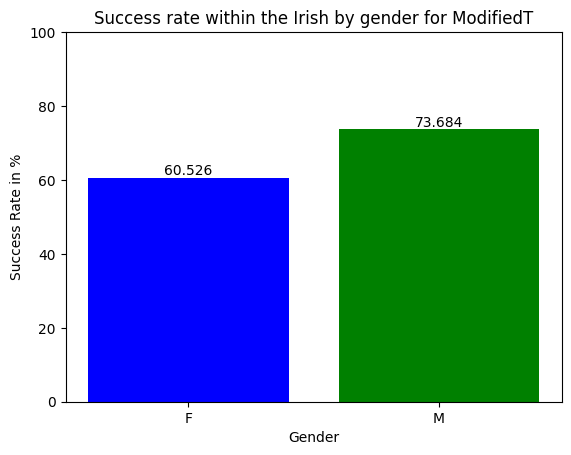

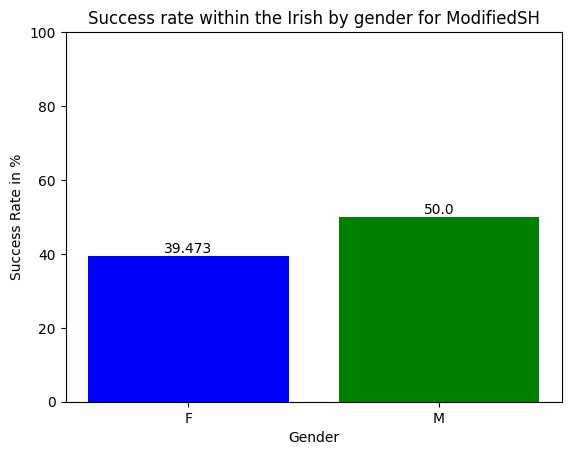

F vs M listeners
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -2.8266514623521015
p-value: 0.004743467995903606



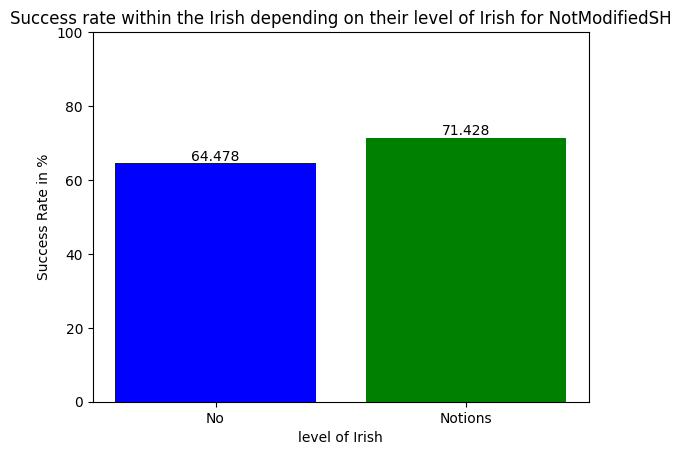

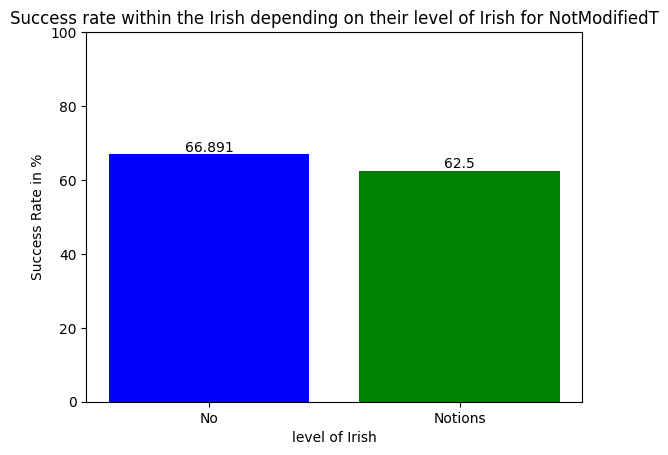

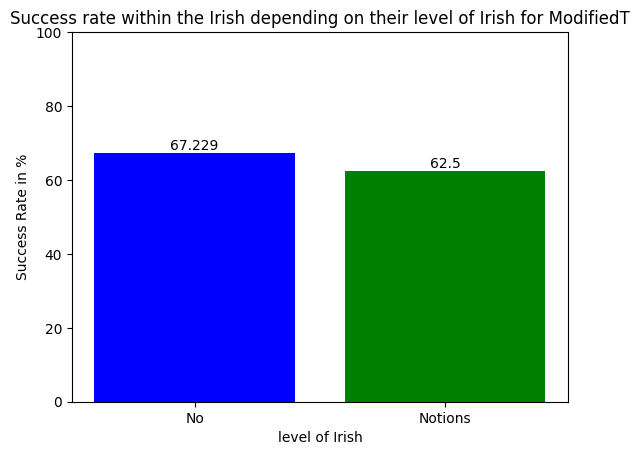

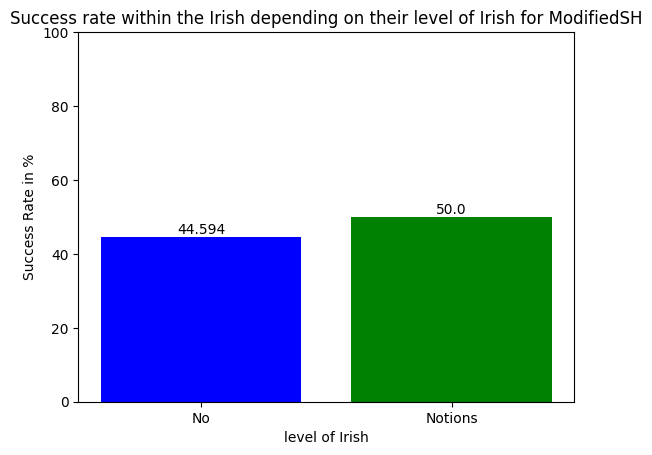

level of Irish yes vs no vs notions
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: 38.84571583788831
p-value: 1.686605260295135e-255



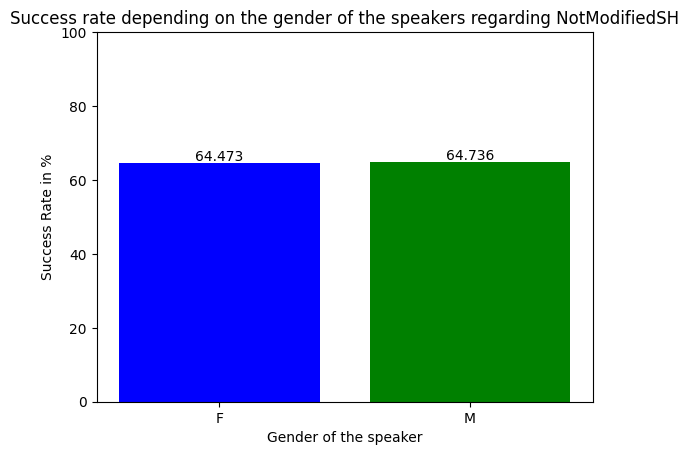

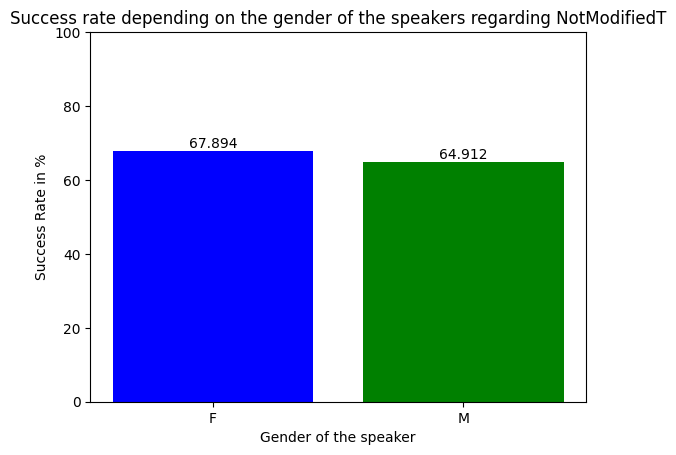

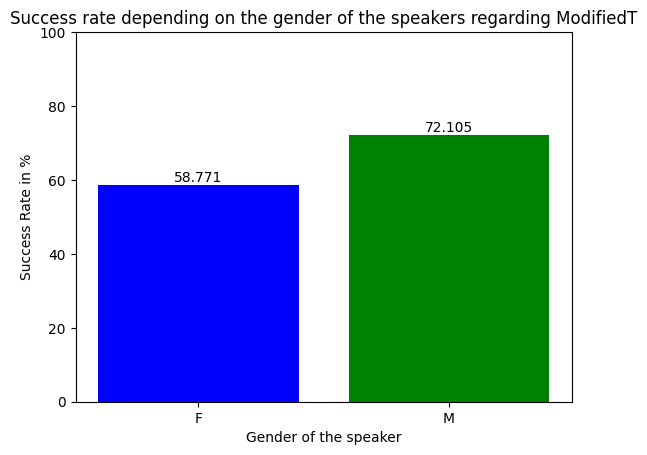

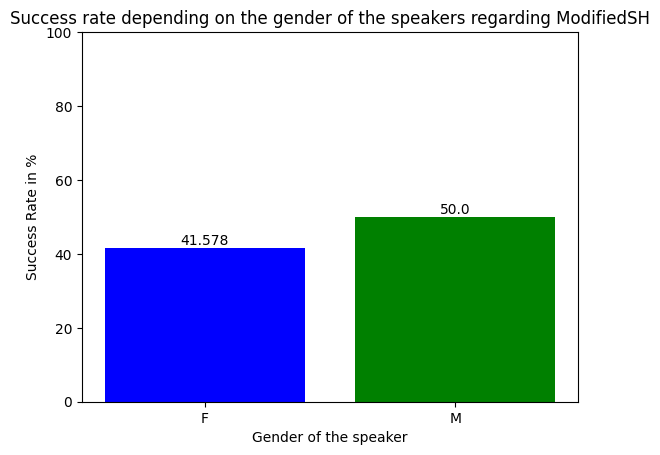

F vs M speakers
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: -3.0067900200729354
p-value: 0.0026681450280286374



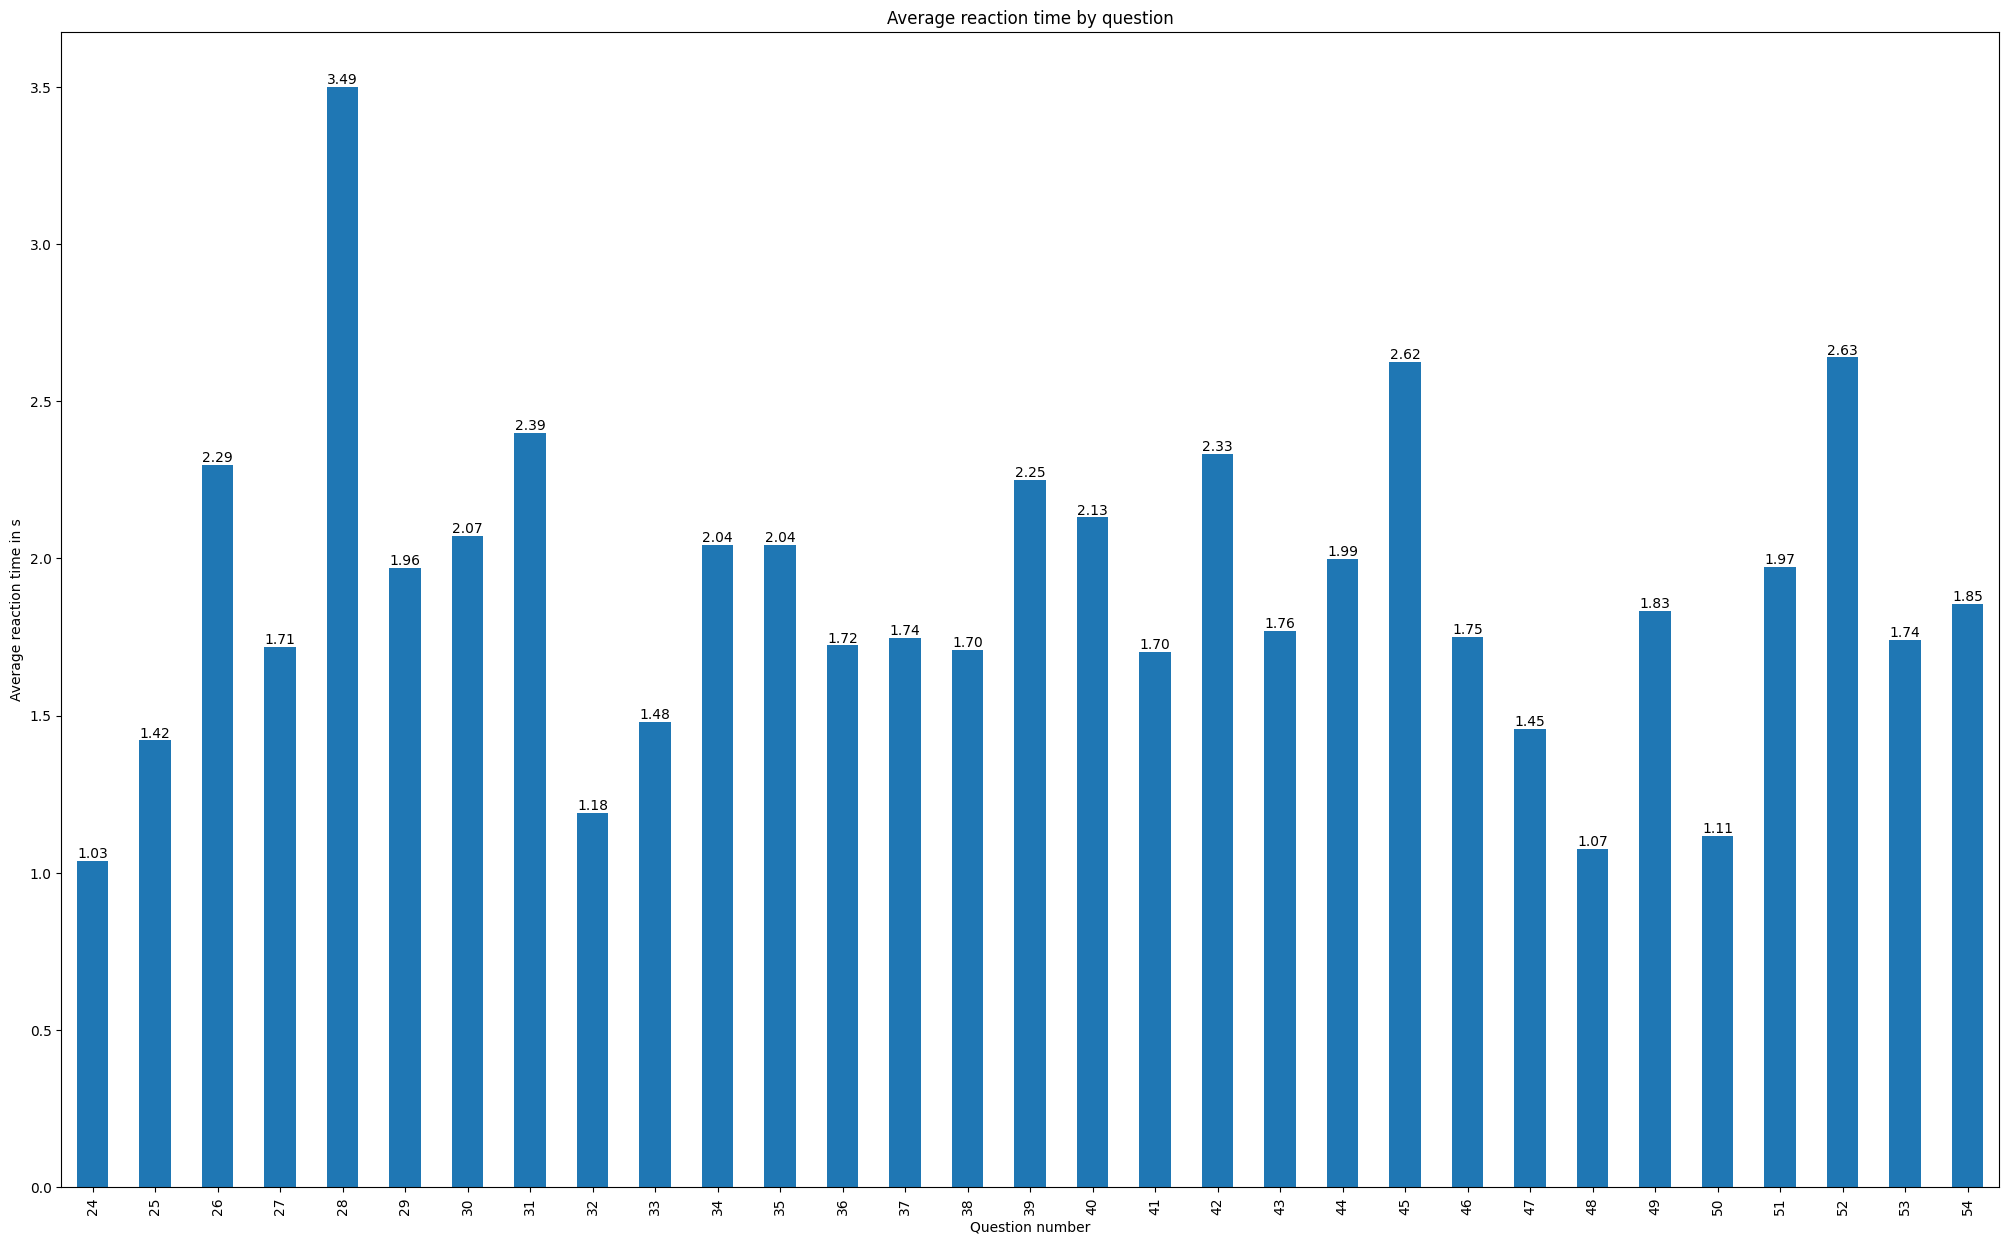

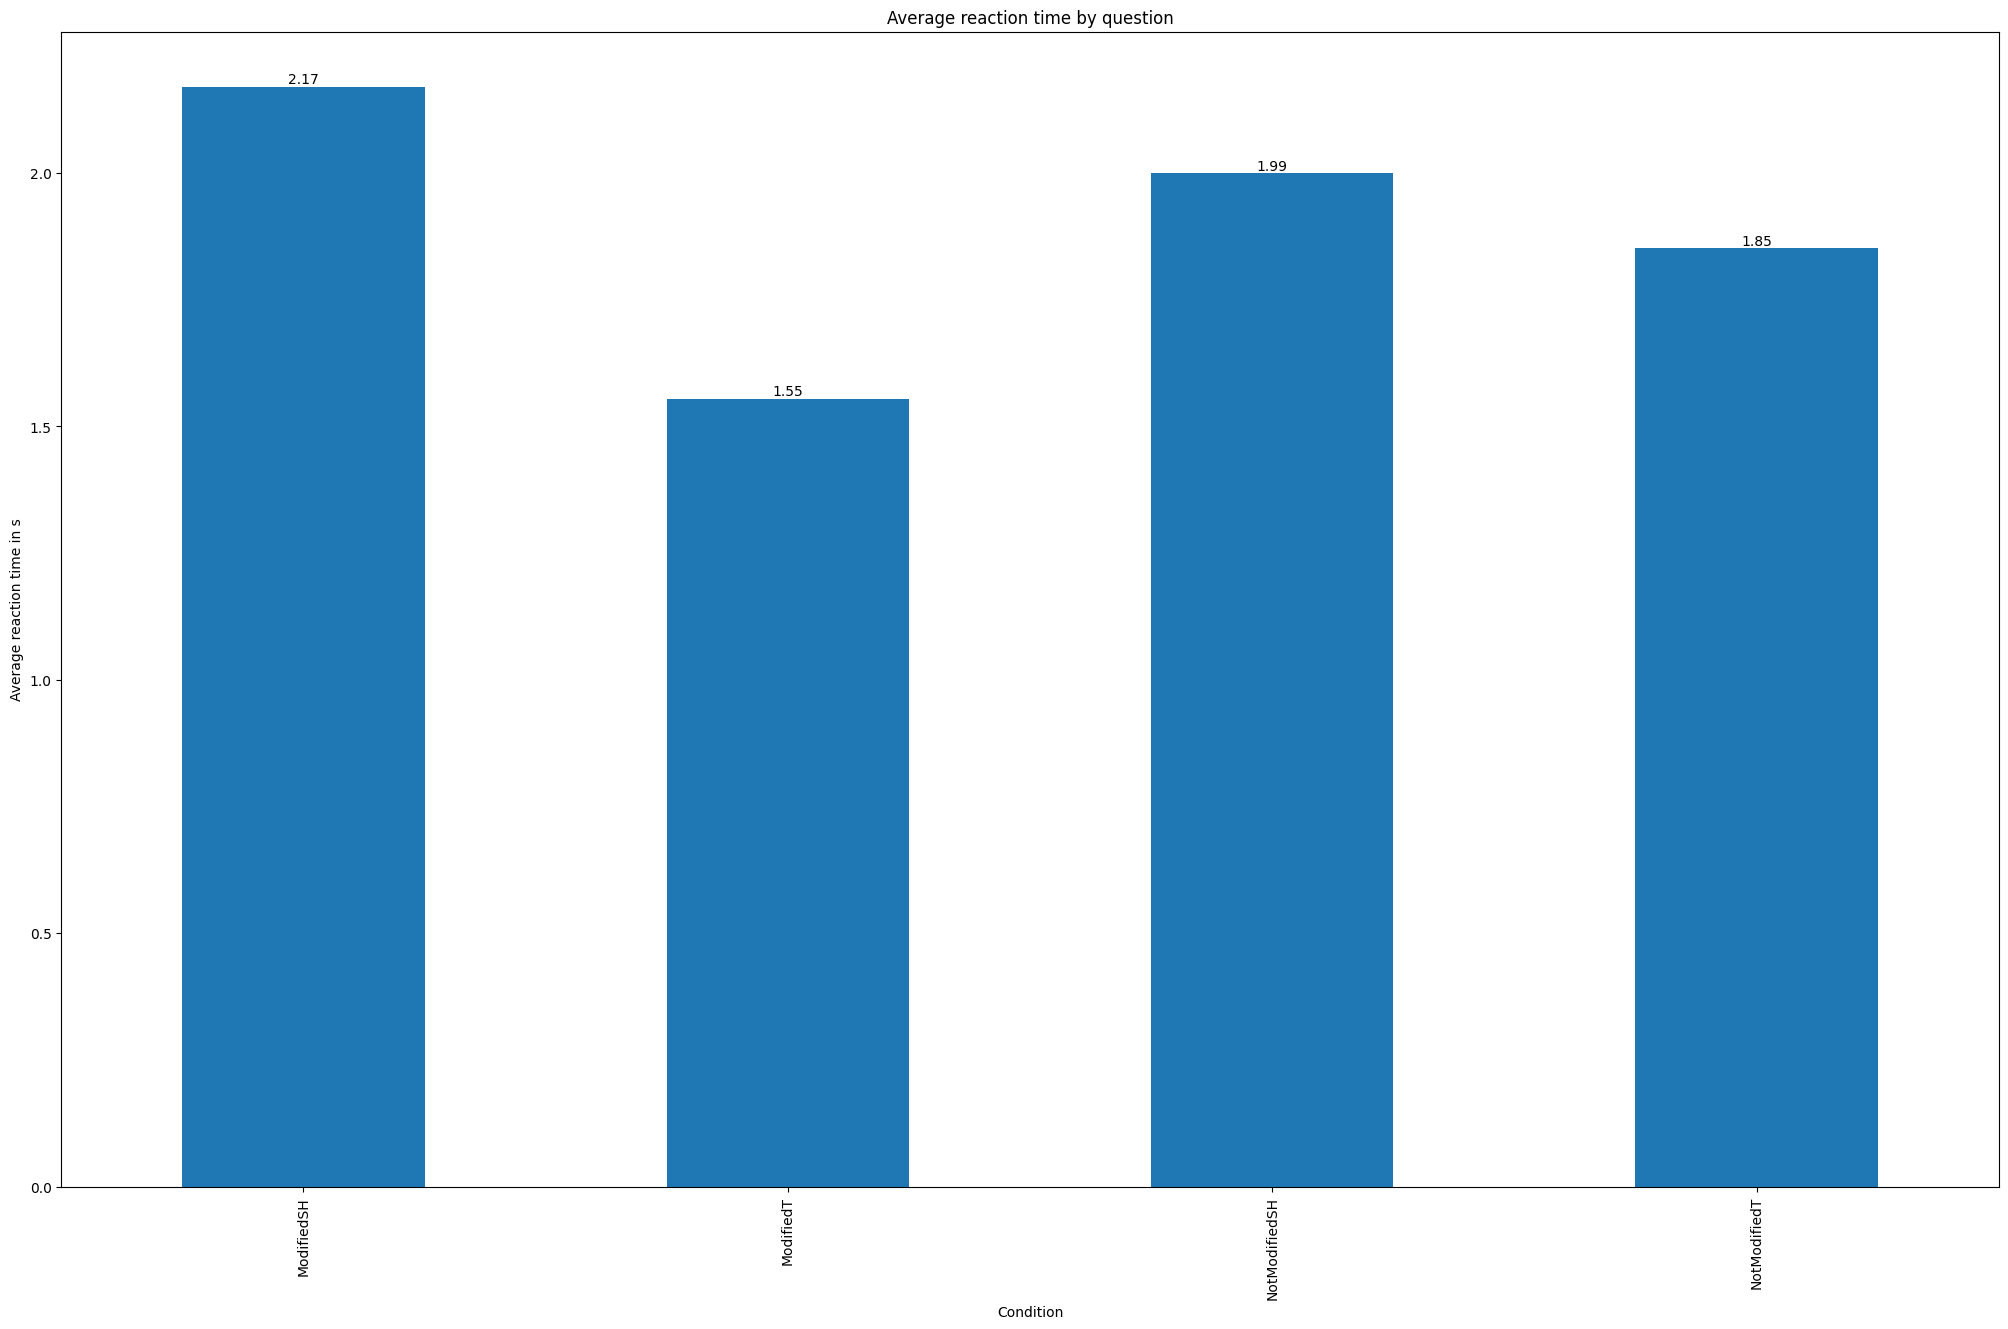

Modified SH vs Modified T
---- Performing Ttest ----
Reject the null hypothesis. There is a significant difference between the means.
t-statistic: 5.691768303005169
p-value: 1.9597363808727877e-08

If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.
Pearson correlation coefficient between Success and Reaction time: -0.09549977256558595



In [108]:
# @title Other English Speaking Countries

#-------Per CONDITION
# Categorize 'Country' into 'Other English Speaking Countries'
filtered_df_lex_mod_t = df_mod_T.loc[df_mod_T['Country'] != 'Ireland']
filtered_df_lex_mod_sh = df_mod_SH.loc[df_mod_SH['Country'] != 'Ireland']
filtered_df_lex_not_mod_t = df_not_mod_T.loc[df_not_mod_T['Country'] != 'Ireland']
filtered_df_lex_not_mod_sh = df_not_mod_SH.loc[df_not_mod_SH['Country'] != 'Ireland']


# Calculate success rate for each condition in Other English Speaking Countries
success_ModifiedT = 100 * filtered_df_lex_mod_t[filtered_df_lex_mod_t['Success'] == 1].shape[0] / filtered_df_lex_mod_t.shape[0]
success_ModifiedSH = 100 * filtered_df_lex_mod_sh[filtered_df_lex_mod_sh['Success'] == 1].shape[0] / filtered_df_lex_mod_sh.shape[0]
success_NotModifiedT = 100 * filtered_df_lex_not_mod_t[filtered_df_lex_not_mod_t['Success'] == 1].shape[0] / filtered_df_lex_not_mod_t.shape[0]
success_NotModifiedSH = 100 * filtered_df_lex_not_mod_sh[filtered_df_lex_not_mod_sh['Success'] == 1].shape[0] / filtered_df_lex_not_mod_sh.shape[0]


headers = ['Modified T','Modified SH','Not Modified SH','Not Modified T']
datas = [success_ModifiedT, success_ModifiedSH, success_NotModifiedSH, success_NotModifiedT]

print(datas)

plot_2d_array(headers, datas, 'Condition', 'Success Rate in %', 'Success rate other English speaking countries per condition', colours=plot_colours80s)

#-------by AGE GROUP----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

filter_withoutIrish = df_lex.loc[df_lex['Country'] != 'Ireland']
for x in condition:
    df = filter_withoutIrish[filter_withoutIrish['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Age_group', 'Age group', 'Success Rate in %',  'Success rate other English speaking countries by age group for ', colours=plot_colours80s)

print('age1 vs age2 vs age3')

val1 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Age'] == 1))
val2 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Age'] == 2))
val3 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Age'] == 3))

do_anova_test([val1, val2, val3])

#------by GENDER----------------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = filter_withoutIrish[filter_withoutIrish['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Gender', 'Gender', 'Success Rate in %',  'Success rate other English speaking countries by gender for ', colours=plot_colours80s)


print('F vs M listeners')
val1 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Gender'] == 'F'))
val2 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Gender'] == 'M'))
do_ttest(val1, val2)


#------by LEVEL OF IRISH---------------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = filter_withoutIrish[filter_withoutIrish['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Irish', 'level of Irish', 'Success Rate in %',  'Success rate other English speaking countries depending on their level of Irish for ', colours=plot_colours80s)


print('level of Irish yes vs no vs notions')
val1 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Irish'] == 'No'))
val2 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Irish'] == 'Notions'))

do_ttest(val1, val2)

#------by GENDER of the speaker-----------------------------------------------------------------------------------------------------------------------------------------------------------------

for x in condition:
    df = filter_withoutIrish[filter_withoutIrish['Condition'] == x]
    plot_success_rate_by_parameter(df, x, 'Condition2', 'Gender of the speaker', 'Success Rate in %',  'Success rate other English speaking countries depending on the gender of the speakers regarding ', colours=plot_colours80s)

print('F vs M speakers')
val1 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Condition2'] == 'F'))
val2 = ((filter_withoutIrish['Success'] == 1) & (filter_withoutIrish['Condition2'] == 'M'))
do_ttest(val1, val2)

#------------Average reaction time in s By ItemNb---------------------------------------------------------------------------------------------------------------------------------------------

plot_bar_average_parameter(filter_withoutIrish, 'ItemNb', 'Question number', 'Average reaction time in s', 'Average reaction time by question', 'Reaction time')

#------------Average reaction time in s By condition

plot_bar_average_parameter(filter_withoutIrish, 'Condition', 'Condition', 'Average reaction time in s', 'Average reaction time by question', 'Reaction time')

#---------TTEST on 'Modified SH vs Modified T'----------------------------------------------------------------------------------------------------------------------------------------------

print('Modified SH vs Modified T')
val1 = ((filtered_df_lex_mod_t['Success'] == 1))
val2 = ((filtered_df_lex_mod_sh['Success'] == 1))
do_ttest(val1, val2)

#-------------------------------------------------------------------------- Calculate Pearson correlation coefficient

correlation = filter_withoutIrish['Success'].corr(filter_withoutIrish['Reaction time'])

print("If it's close to -1, it indicates a strong negative correlation (as one variable increases, the other tends to decrease). If it's close to 0, it indicates no linear correlation between the variables.")

print("Pearson correlation coefficient between Success and Reaction time:", correlation)

print("")



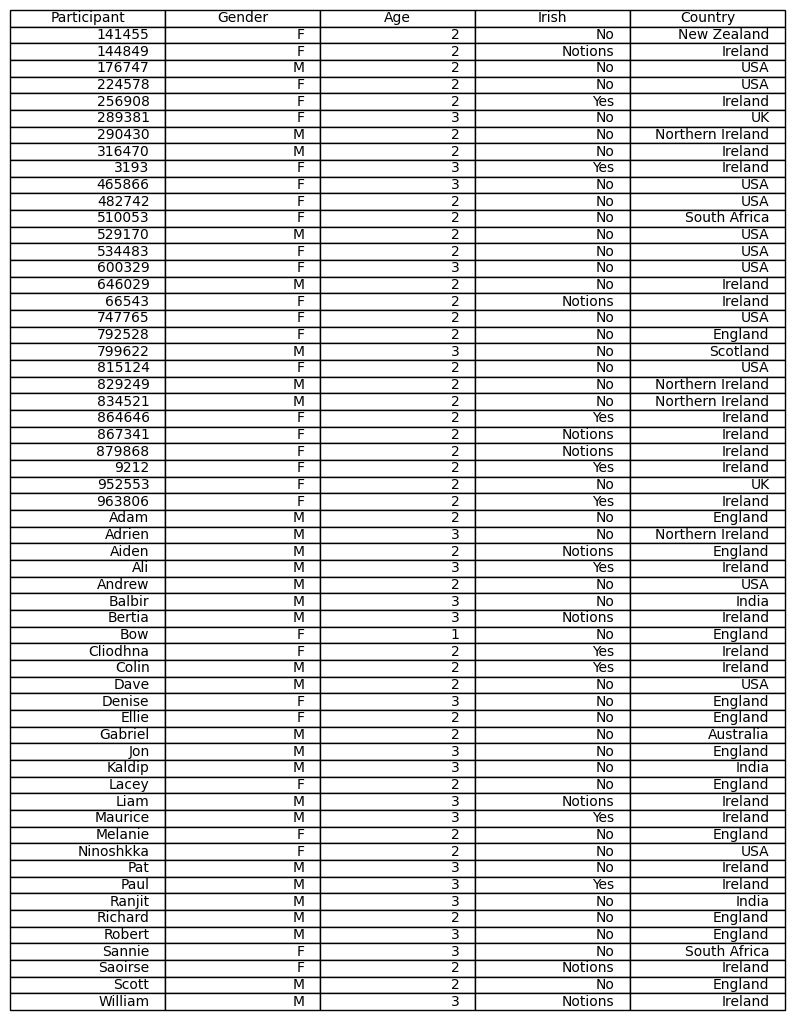

In [106]:
# @title TABLE PARTICIPANTS

#Group by 'Participant' and select the first row of each group
unique_participants_df = df_lex.groupby('Participant').first().reset_index()

# Select the columns you want
selected_columns = ['Participant', 'Gender', 'Age', 'Irish', 'Country']

# Create a new DataFrame with only the selected columns
table_df = unique_participants_df[selected_columns]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes
ax.axis('off')

# Plot the table
table = ax.table(cellText=table_df.values,
                 colLabels=table_df.columns,
                 loc='center')

# Adjust the font size
table.auto_set_font_size(False)
table.set_fontsize(10)

# Save the figure as an image
plt.savefig('participant_table.png', bbox_inches='tight')


                              Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               Success   
No. Observations:               1829                  Method:                           REML      
No. Groups:                     59                    Scale:                            0.2172    
Min. group size:                31                    Log-Likelihood:                   -1239.9904
Max. group size:                31                    Converged:                        Yes       
Mean group size:                31.0                                                              
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

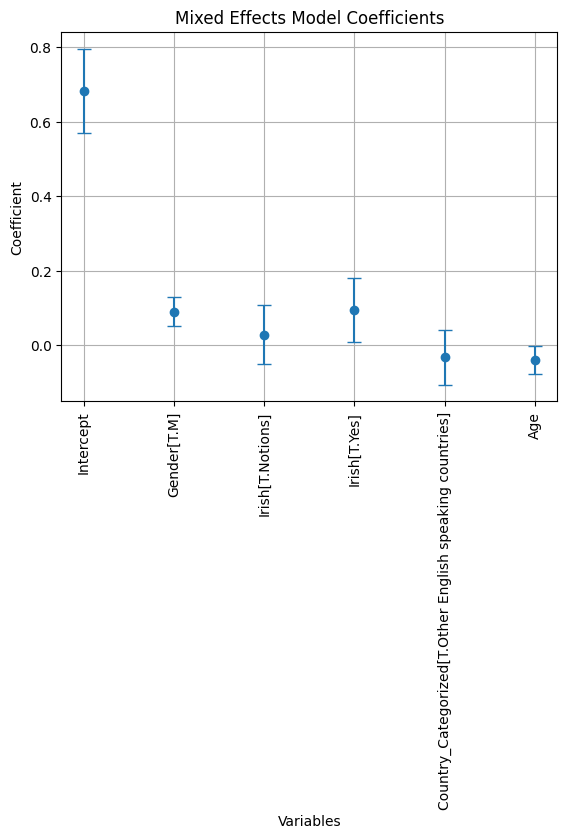

In [105]:
# @title MIXED EFFECTS MODEL all participants


# Fit the mixed effects model
model = smf.mixedlm("Success ~ Gender + Age + Irish + Country_Categorized", df_lex, groups=df_lex["Participant"])
result = model.fit()

# Print the summary of the model
print(result.summary())

# Extract the coefficients and standard errors
coefs = result.fe_params
stderr = result.bse_fe

# Plot the coefficients with error bars
plt.errorbar(coefs.index, coefs.values, yerr=stderr, fmt='o', capsize=5)
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.title('Mixed Effects Model Coefficients')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()



           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Success  
No. Observations:   651      Method:              REML     
No. Groups:         21       Scale:               0.2014   
Min. group size:    31       Log-Likelihood:      -422.1750
Max. group size:    31       Converged:           Yes      
Mean group size:    31.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.663    0.196  3.382 0.001  0.279  1.048
Gender[T.M]       0.041    0.108  0.379 0.705 -0.170  0.252
Irish[T.Notions]  0.032    0.127  0.250 0.803 -0.217  0.281
Irish[T.Yes]      0.089    0.124  0.719 0.472 -0.154  0.333
Age              -0.021    0.100 -0.207 0.836 -0.217  0.176
Group Var         0.018    0.019                           



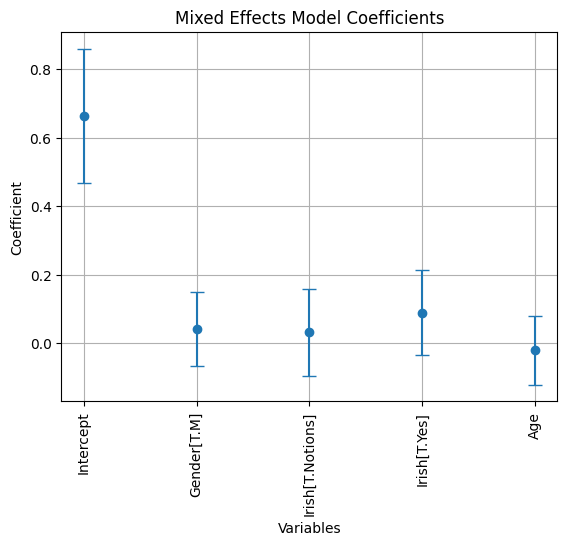

In [104]:
# @title MIXED EFFECTS MODEL within the Irish


df_lex.head()

# Fit the mixed effects model
model = smf.mixedlm("Success ~ Gender + Age + Irish", filter_withinIrish, groups=filter_withinIrish["Participant"])
result = model.fit()

# Print the summary of the model
print(result.summary())

# Extract the coefficients and standard errors
coefs = result.fe_params
stderr = result.bse_fe

# Plot the coefficients with error bars
plt.errorbar(coefs.index, coefs.values, yerr=stderr, fmt='o', capsize=5)
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.title('Mixed Effects Model Coefficients')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Success  
No. Observations:   1178     Method:              REML     
No. Groups:         38       Scale:               0.2259   
Min. group size:    31       Log-Likelihood:      -819.4396
Max. group size:    31       Converged:           Yes      
Mean group size:    31.0                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.641    0.103  6.222 0.000  0.439  0.842
Gender[T.M]       0.117    0.046  2.562 0.010  0.027  0.206
Irish[T.Notions] -0.065    0.141 -0.464 0.642 -0.342  0.211
Age              -0.039    0.044 -0.888 0.375 -0.126  0.048
Group Var         0.011    0.010                           



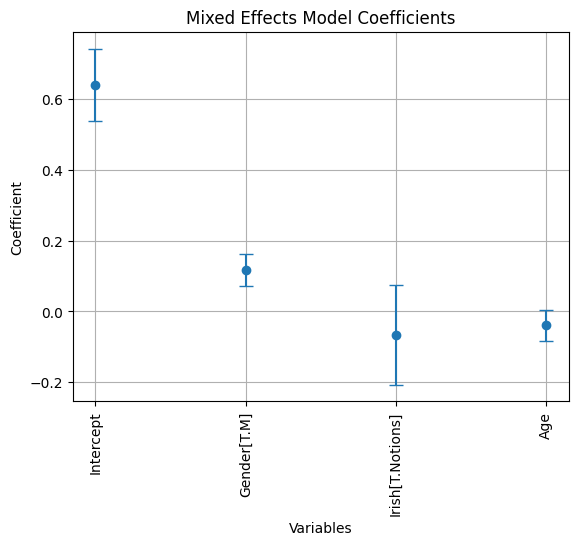

In [110]:
# @title MIXED EFFECTS MODEL with other countries


df_lex.head()

# Fit the mixed effects model
model = smf.mixedlm("Success ~ Gender + Age + Irish", filter_withoutIrish, groups=filter_withoutIrish["Participant"])
result = model.fit()

# Print the summary of the model
print(result.summary())

# Extract the coefficients and standard errors
coefs = result.fe_params
stderr = result.bse_fe

# Plot the coefficients with error bars
plt.errorbar(coefs.index, coefs.values, yerr=stderr, fmt='o', capsize=5)
plt.xlabel('Variables')
plt.ylabel('Coefficient')
plt.title('Mixed Effects Model Coefficients')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

### Table

In [ ]:
# @title Age

from matplotlib import pyplot as plt
df_lex['Age'].plot(kind='line', figsize=(8, 4), title='Age')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
from scipy import stats
import pandas as pd

# Load data from CSV file
df_lex = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

# Calculate success rate for females and males
success_count_F = ((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                  (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])) &
                  (df_lex['Condition2'] == "F")).sum()

success_count_M = ((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                  (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])) &
                  (df_lex['Condition2'] == "M")).sum()

total_count = len(df_lex)

success_rate_F = success_count_F / total_count
success_rate_M = success_count_M / total_count

print("Success rate F:", success_rate_F)
print("Success rate M:", success_rate_M)

# Perform independent samples t-test for both genders on modified sounds

modified_ttest_gender_M = ((df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])) &
                          (df_lex['Condition2'] == "M"))

modified_ttest_gender_F = ((df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])) &
                          (df_lex['Condition2'] == "F"))

t_statistic, p_value = stats.ttest_ind(modified_ttest_gender_M, modified_ttest_gender_F)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the t-statistic and p-value
print("\n--- Modified TTest ---")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

###########

# Perform independent samples t-test for both genders on NOT modified sounds

not_modified_ttest_gender_M = ((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) &
                          (df_lex['Condition2'] == "M"))

not_modified_ttest_gender_F = ((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) &
                          (df_lex['Condition2'] == "F"))

t_statistic, p_value = stats.ttest_ind(not_modified_ttest_gender_M, not_modified_ttest_gender_F)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the t-statistic and p-value
print("\n--- Not modified TTest ---")
print("t-statistic:", t_statistic)
print("p-value:", p_value)


#########

new_M_values = ((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])) &
                (df_lex['Condition2'] == "M"))

new_F_values = ((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])) &
                (df_lex['Condition2'] == "F"))

# Perform independent samples t-test
t_statistic, p_value = stats.ttest_ind(new_M_values, new_F_values)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the t-statistic and p-value
print("\n--- All together TTest ---")
print("t-statistic:", t_statistic)
print("p-value:", p_value)


Success rate F: 0.46236559139784944
Success rate M: 0.48966087675765096
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.

--- Modified TTest ---
t-statistic: 1.8968008895973905
p-value: 0.057973384972399254
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.

--- Not modified TTest ---
t-statistic: 1.3161279665568204
p-value: 0.18825595043193355
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.

--- All together TTest ---
t-statistic: 1.3436886574223559
p-value: 0.17917526563100492


In [ ]:
from scipy import stats
import pandas as pd

# Load data from CSV file
df_lex = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')
print(df_lex.shape)
df_lex.head()

 # Calculate success rate
success_count_F = 0
success_count_M = 0
for index in df_lex.index:
  #we make a variable that contains the lines (index is the number of the line)
  line = df_lex.loc[index]

  if ((line["Condition"] in ("NotModifiedT", "NotModifiedSH") and line['ExpectedKey'] == line['key_resp_question3.keys'])
      or (line['Condition'] in ["ModifiedT", "ModifiedSH"] and line['ExpectedKey'] != line['key_resp_question3.keys'])):
      if line['Condition2'] == "F":
        success_count_F += 1
      else:
        success_count_M += 1

#success_count = (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys']).sum()
total_count = len(df_lex)

success_rate_F = (success_count_F / total_count)
success_rate_M = (success_count_M / total_count)

print("Success rate F:", success_rate_F)
print("Success rate M:", success_rate_M)
# Extract the relevant columns for your comparison
# For example, if you have two groups 'group1' and 'group2'

# Perform independent samples t-test
t_statistic, p_value = stats.ttest_ind(success_rate_F, success_rate_M)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the t-statistic and p-value
print("t-statistic:", t_statistic)
print("p-value:", p_value)

(1209, 11)
Success rate F: 0.2878411910669975
Success rate M: 0.3349875930521092
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
t-statistic: nan
p-value: nan


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7030: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


In [ ]:
from scipy import stats
import pandas as pd

# Load data from CSV file
df_lex = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')


# Filter data for participants from Ireland
ireland_data = df_lex[df_lex['Country'] == 'Ireland']


# Calculate success rate for females and males
success_count_F = ((ireland_data['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (ireland_data['ExpectedKey'] == ireland_data['key_resp_question3.keys'])) |
                  (ireland_data['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (ireland_data['ExpectedKey'] != ireland_data['key_resp_question3.keys'])) &
                  (ireland_data['Condition2'] == "F")).sum()

success_count_M = ((ireland_data['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (ireland_data['ExpectedKey'] == ireland_data['key_resp_question3.keys'])) |
                  (ireland_data['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (ireland_data['ExpectedKey'] != ireland_data['key_resp_question3.keys'])) &
                  (ireland_data['Condition2'] == "M")).sum()

total_count = len(ireland_data)

success_rate_F = success_count_F / total_count
success_rate_M = success_count_M / total_count

print("Success rate F:", success_rate_F)
print("Success rate M:", success_rate_M)

# Perform independent samples t-test for both genders on modified sounds

modified_ttest_gender_M = ((ireland_data['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (ireland_data['ExpectedKey'] != ireland_data['key_resp_question3.keys'])) &
                          (ireland_data['Condition2'] == "M"))

modified_ttest_gender_F = ((ireland_data['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (ireland_data['ExpectedKey'] != ireland_data['key_resp_question3.keys'])) &
                          (ireland_data['Condition2'] == "F"))

t_statistic, p_value = stats.ttest_ind(modified_ttest_gender_M, modified_ttest_gender_F)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the t-statistic and p-value
print("\n--- Modified TTest ---")
print("t-statistic:", t_statistic)
print("p-value:", p_value)

###########

# Perform independent samples t-test for both genders on NOT modified sounds

not_modified_ttest_gender_M = ((ireland_data['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (ireland_data['ExpectedKey'] == ireland_data['key_resp_question3.keys'])) &
                          (ireland_data['Condition2'] == "M"))

not_modified_ttest_gender_F = ((ireland_data['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (ireland_data['ExpectedKey'] == ireland_data['key_resp_question3.keys'])) &
                          (ireland_data['Condition2'] == "F"))

t_statistic, p_value = stats.ttest_ind(not_modified_ttest_gender_M, not_modified_ttest_gender_F)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the t-statistic and p-value
print("\n--- Not modified TTest ---")
print("t-statistic:", t_statistic)
print("p-value:", p_value)


#########

new_M_values = ((ireland_data['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (ireland_data['ExpectedKey'] == ireland_data['key_resp_question3.keys'])) |
                (ireland_data['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (ireland_data['ExpectedKey'] != ireland_data['key_resp_question3.keys'])) &
                (ireland_data['Condition2'] == "M"))

new_F_values = ((ireland_data['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (ireland_data['ExpectedKey'] == ireland_data['key_resp_question3.keys'])) |
                (ireland_data['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (ireland_data['ExpectedKey'] != ireland_data['key_resp_question3.keys'])) &
                (ireland_data['Condition2'] == "F"))

# Perform independent samples t-test
t_statistic, p_value = stats.ttest_ind(new_M_values, new_F_values)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the t-statistic and p-value
print("\n--- All together TTest ---")
print("t-statistic:", t_statistic)
print("p-value:", p_value)


Success rate F: 0.5278592375366569
Success rate M: 0.5454545454545454
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.

--- Modified TTest ---
t-statistic: 0.6194150504321799
p-value: 0.5358504418768788
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.

--- Not modified TTest ---
t-statistic: 0.8845009397345714
p-value: 0.3767384858376661
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.

--- All together TTest ---
t-statistic: 0.46013919060166497
p-value: 0.6455634090135661


In [ ]:
from scipy import stats
import pandas as pd

# Load data from CSV file
df_lex = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

# Calculate success rate for each age group
success_1 = ((df_lex['Age'] == 1) &
                   (((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                    (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])))))

success_2 = ((df_lex['Age'] == 2) &
                   (((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                     (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])))))

success_3 = ((df_lex['Age'] == 3) &
                   (((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                     (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])))))

total_count = len(df_lex)

success_rate_1 = success_1.sum() / total_count
success_rate_2 = success_2.sum() / total_count
success_rate_3 = success_3.sum() / total_count

print("For both modified and not modified phones")
print("Success rate Age 1:", success_rate_1)
print("Success rate Age 2:", success_rate_2)
print("Success rate Age 3:", success_rate_3)

# Perform ANOVA test for both modified and not modified
f_statistic, p_value = stats.f_oneway(success_1, success_2, success_3)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between at least one pair of means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Perform one-sample t-test for each age group against the population mean (0.5 for binary success/failure)
t_statistic_1, p_value_1 = stats.ttest_ind(success_1, success_2)
t_statistic_2, p_value_2 = stats.ttest_ind(success_1, success_3)
t_statistic_3, p_value_3 = stats.ttest_ind(success_2, success_3)

# Print results
print("Age 1 - 2:")
print("  t-statistic:", t_statistic_1)
print("  p-value:", p_value_1)
if p_value_1 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

print("Age 1 - 3:")
print("  t-statistic:", t_statistic_2)
print("  p-value:", p_value_2)
if p_value_2 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

print("Age 2 - 3:")
print("  t-statistic:", t_statistic_3)
print("  p-value:", p_value_3)
if p_value_3 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")


For both modified and not modified phones
Success rate Age 1: 0.018975332068311195
Success rate Age 2: 0.34345351043643263
Success rate Age 3: 0.27798861480075904
Reject the null hypothesis. There is a significant difference between at least one pair of means.
F-statistic: 209.09899283021383
p-value: 5.2179644230810455e-86
Age 1 - 2:
  t-statistic: -21.311217451424575
  p-value: 2.0403457506572306e-91
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.
Age 1 - 3:
  t-statistic: -17.946962324531267
  p-value: 3.93241949877838e-67
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.
Age 2 - 3:
  t-statistic: 3.2539721584914902
  p-value: 0.0011560496660501783
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.


In [ ]:
from scipy import stats
import pandas as pd

# Load data from CSV file
df_lex = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

# Calculate success rate for each age group
success_1 = ((df_lex['Age'] == 1) &
                    (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])))

success_2 = ((df_lex['Age'] == 2) &
                     (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])))

success_3 = ((df_lex['Age'] == 3) &
                     (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys'])))

total_count = len(df_lex)

success_rate_1 = success_1.sum() / total_count
success_rate_2 = success_2.sum() / total_count
success_rate_3 = success_3.sum() / total_count

print("For modified phones")
print("Success rate Age 1:", success_rate_1)
print("Success rate Age 2:", success_rate_2)
print("Success rate Age 3:", success_rate_3)

# Perform ANOVA test for modified
f_statistic, p_value = stats.f_oneway(success_1, success_2, success_3)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between at least one pair of means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Perform one-sample t-test for each age group against the population mean (0.5 for binary success/failure)
t_statistic_1, p_value_1 = stats.ttest_ind(success_1, success_2)
t_statistic_2, p_value_2 = stats.ttest_ind(success_1, success_3)
t_statistic_3, p_value_3 = stats.ttest_ind(success_2, success_3)

# Print results
print("Age 1 - 2:")
print("  t-statistic:", t_statistic_1)
print("  p-value:", p_value_1)
if p_value_1 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

print("Age 1 - 3:")
print("  t-statistic:", t_statistic_2)
print("  p-value:", p_value_2)
if p_value_2 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

print("Age 2 - 3:")
print("  t-statistic:", t_statistic_3)
print("  p-value:", p_value_3)
if p_value_3 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")


For modified phones
Success rate Age 1: 0.009487666034155597
Success rate Age 2: 0.16223908918406071
Success rate Age 3: 0.13282732447817835
Reject the null hypothesis. There is a significant difference between at least one pair of means.
F-statistic: 79.6536992947307
p-value: 1.7817228666845283e-34
Age 1 - 2:
  t-statistic: -13.003010188370075
  p-value: 3.0661628098317318e-37
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.
Age 1 - 3:
  t-statistic: -11.33938478925748
  p-value: 5.687079647000921e-29
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.
Age 2 - 3:
  t-statistic: 1.9046288622578573
  p-value: 0.05696445103918943
  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.


In [ ]:
#all participants age group T Test
from scipy import stats
import pandas as pd

# Load data from CSV file
df_lex = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

# Calculate success rate for each age group
success_1 = ((df_lex['Age'] == 1) &
              (df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])))

success_2 = ((df_lex['Age'] == 2) &
                   (df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])))

success_3 = ((df_lex['Age'] == 3) &
                (df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])))

total_count = len(df_lex)

success_rate_1 = success_1.sum() / total_count
success_rate_2 = success_2.sum() / total_count
success_rate_3 = success_3.sum() / total_count

print("For not modified phones")
print("Success rate Age 1:", success_rate_1)
print("Success rate Age 2:", success_rate_2)
print("Success rate Age 3:", success_rate_3)

# Perform ANOVA test for not modified
f_statistic, p_value = stats.f_oneway(success_1, success_2, success_3)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between at least one pair of means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Perform one-sample t-test for each age group against the population mean (0.5 for binary success/failure)
t_statistic_1, p_value_1 = stats.ttest_ind(success_1, success_2)
t_statistic_2, p_value_2 = stats.ttest_ind(success_1, success_3)
t_statistic_3, p_value_3 = stats.ttest_ind(success_2, success_3)

# Print results
print("Age 1 - 2:")
print("  t-statistic:", t_statistic_1)
print("  p-value:", p_value_1)
if p_value_1 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

print("Age 1 - 3:")
print("  t-statistic:", t_statistic_2)
print("  p-value:", p_value_2)
if p_value_2 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

print("Age 2 - 3:")
print("  t-statistic:", t_statistic_3)
print("  p-value:", p_value_3)
if p_value_3 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")


For not modified phones
Success rate Age 1: 0.009487666034155597
Success rate Age 2: 0.18121442125237192
Success rate Age 3: 0.14516129032258066
Reject the null hypothesis. There is a significant difference between at least one pair of means.
F-statistic: 91.89697118731759
p-value: 1.6125406217092756e-39
Age 1 - 2:
  t-statistic: -14.029275713402688
  p-value: 8.20068962956006e-43
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.
Age 1 - 3:
  t-statistic: -12.050079092765108
  p-value: 2.1937007248884465e-32
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.
Age 2 - 3:
  t-statistic: 2.2413083810477357
  p-value: 0.025109904315087597
  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.


In [ ]:
#all participants age group Anova

# Calculate success rate for each age group
success_rates = []
age_groups = df_lex['Age'].unique()

for age_group in age_groups:
    success_count = ((df_lex['Age'] == age_group) &
                     (((df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])) |
                       (df_lex['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys']))))
                    ).sum()
    total_count = len(df_lex[df_lex['Age'] == age_group])
    success_rate = success_count / total_count
    success_rates.append(success_rate)

print("Success rates by age group:", success_rates)

# Perform ANOVA test
f_statistic, p_value = stats.f_oneway(*(df_lex[df_lex['Age'] == age_group]['ExpectedKey'] == df_lex[df_lex['Age'] == age_group]['key_resp_question3.keys'] for age_group in age_groups))

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between at least one pair of means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)


Success rates by age group: [0.6146010186757216, 0.6751152073732719, 0.6451612903225806]
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
F-statistic: 0.07107073680700661
p-value: 0.9314004816643349


In [ ]:
#all aprticipants' level of irish
from scipy import stats
import pandas as pd

# Load data from CSV file
df_lex = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')


# Filter data for different groups
irish_data = df_lex[df_lex['Irish'] == 'Yes']
not_irish_data = df_lex[df_lex['Irish'] == 'No']
notions_data = df_lex[df_lex['Irish'] == 'Notions']

# Define success conditions based on the Condition column
def calculate_success_rate(data):
    if df_lex['Condition'].isin(['ModifiedT', 'ModifiedSH']).any():
        return (df_lex['ExpectedKey'] != df_lex['key_resp_question3.keys']).mean()
    else:
        return (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys']).mean()

# Calculate success rates for each group
success_rate_irish = calculate_success_rate(irish_data)
success_rate_not_irish = calculate_success_rate(not_irish_data)
success_rate_notions = calculate_success_rate(notions_data)

print("Success rate for people who speak Irish:", success_rate_irish)
print("Success rate for people who don't speak Irish:", success_rate_not_irish)
print("Success rate for people with 'Notions':", success_rate_notions)

# Perform ANOVA test to compare the means of the success rates
f_statistic, p_value = stats.f_oneway(irish_data['ExpectedKey'] == irish_data['key_resp_question3.keys'],
                                      not_irish_data['ExpectedKey'] == not_irish_data['key_resp_question3.keys'],
                                      notions_data['ExpectedKey'] == notions_data['key_resp_question3.keys'])

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)


Success rate for people who speak Irish: 0.452561669829222
Success rate for people who don't speak Irish: 0.452561669829222
Success rate for people with 'Notions': 0.452561669829222
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
F-statistic: 0.05067821704791455
p-value: 0.9505868259659137


In [ ]:
from scipy import stats
import pandas as pd

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

# Filter data for participants from Ireland
ireland_data = data[data['Country'] == 'Ireland']

# Define success conditions based on the Condition column
def calculate_success_rate(data):
    if ireland_data['Condition'].isin(['ModifiedT', 'ModifiedSH']).any():
        return (ireland_data['ExpectedKey'] != ireland_data['key_resp_question3.keys']).mean()
    else:
        return (ireland_data['ExpectedKey'] == ireland_data['key_resp_question3.keys']).mean()

# Calculate success rate for participants from Ireland
success_rate_ireland = calculate_success_rate(ireland_data)

print("Success rate for participants from Ireland:", success_rate_ireland)


Success rate for participants from Ireland: 0.43424317617866004


In [ ]:
from scipy import stats
import pandas as pd

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

# Filter data for participants from Ireland
notireland_data = data[data['Country'] != 'Ireland']

# Define success conditions based on the Condition column
def calculate_success_rate(data):
    if data['Condition'].isin(['ModifiedT', 'ModifiedSH']).any():
        return (data['ExpectedKey'] != data['key_resp_question3.keys']).mean()
    else:
        return (data['ExpectedKey'] == data['key_resp_question3.keys']).mean()

# Calculate success rate for participants from Ireland
success_rate_notireland = calculate_success_rate(notireland_data)

print("Success rate for participants from Ireland:", success_rate_notireland)

# Calculate success rate for each age group
success_1 = ((df_lex['Country'] == 'Ireland') &
              (df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])))

success_2 = ((df_lex['Country'] != 'Ireland') &
                   (df_lex['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (df_lex['ExpectedKey'] == df_lex['key_resp_question3.keys'])))


total_count = len(df_lex)

success_rate_1 = success_1.sum() / total_count
success_rate_1 = success_2.sum() / total_count

# Perform one-sample t-test for each age group against the population mean (0.5 for binary success/failure)
t_statistic_1, p_value_1 = stats.ttest_ind(success_rate_1, success_rate_1)

# Print results
print("Succes rate Irish vs Non Irish:")
print("  t-statistic:", t_statistic_1)
print("  p-value:", p_value_1)
if p_value_1 < 0.05:
    print("  Reject the null hypothesis. There is a significant difference between the mean success rate and the population mean.")
else:
    print("  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

Success rate for participants from Ireland: 0.45533498759305213
Succes rate Irish vs Non Irish:
  t-statistic: nan
  p-value: nan
  Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7030: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


In [ ]:
from scipy import stats
import pandas as pd

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

# Filter data for participants from Ireland
ireland_data = data[data['Country'] == 'Ireland']

# Define success conditions based on the Condition column
def calculate_success_rate(data):
    if data['Condition'].isin(['ModifiedT', 'ModifiedSH']).any():
        return (data['ExpectedKey'] != data['key_resp_question3.keys']).mean()
    else:
        return (data['ExpectedKey'] == data['key_resp_question3.keys']).mean()

# Calculate success rates for different Irish language proficiency levels
irish_data_no = ireland_data[ireland_data['Irish'] == 'No']
irish_data_notions = ireland_data[ireland_data['Irish'] == 'Notions']
irish_data_yes = ireland_data[ireland_data['Irish'] == 'Yes']

success_rate_no = calculate_success_rate(irish_data_no)
success_rate_notions = calculate_success_rate(irish_data_notions)
success_rate_yes = calculate_success_rate(irish_data_yes)

print("Success rate for participants from Ireland with Irish proficiency 'No':", success_rate_no)
print("Success rate for participants from Ireland with Irish proficiency 'Notions':", success_rate_notions)
print("Success rate for participants from Ireland with Irish proficiency 'Yes':", success_rate_yes)

# Perform ANOVA test to compare the means of the success rates
f_statistic, p_value = stats.f_oneway(irish_data_no['ExpectedKey'] == irish_data_no['key_resp_question3.keys'],
                                      irish_data_notions['ExpectedKey'] == irish_data_notions['key_resp_question3.keys'],
                                      irish_data_yes['ExpectedKey'] == irish_data_yes['key_resp_question3.keys'])

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)


Success rate for participants from Ireland with Irish proficiency 'No': 0.43010752688172044
Success rate for participants from Ireland with Irish proficiency 'Notions': 0.4435483870967742
Success rate for participants from Ireland with Irish proficiency 'Yes': 0.4435483870967742
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
F-statistic: 0.024581818181818187
p-value: 0.9757195983818625


In [ ]:
# Reaction time

import pandas as pd
import numpy as np
from scipy.stats import f_oneway

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/R/LexicalDecision.csv')

# Group the DataFrame by 'Condition' and calculate the mean 'Reaction time' for each group
mean_reaction_time_by_condition = data.groupby('Condition')['Reaction time'].mean()

print(mean_reaction_time_by_condition['ModifiedT'])

modified_T = mean_reaction_time_by_condition.get('ModifiedT', None)
not_modified_T = mean_reaction_time_by_condition.get('NotModifiedT', None)

modified_SH = mean_reaction_time_by_condition.get('ModifiedSH', None)
not_modified_SH = mean_reaction_time_by_condition.get('NotModifiedSH', None)

print(modified_T, not_modified_T, modified_SH, not_modified_SH)

if np.isnan(modified_T).any() or np.isnan(not_modified_T).any():
    print("One or both of the arrays contain NaN values.")
else:
    # Perform independent samples t-test
    t_statistic, p_value = stats.ttest_1samp([modified_T, not_modified_T], 2)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)


1.6550725459558824
1.6550725459558824 1.6910986801470589 2.015242265073529 1.852528031932773
Reject the null hypothesis. There is a significant difference between the groups.
F-statistic: nan
p-value: 0.03504247899357377


In [ ]:
#Success rate depending on age within the Irish participants


# Filter data for participants from Ireland
ireland_data = df_lex.loc[df_lex['Country'] == 'Ireland']


# Calculate success rate for each age group
success_rates = []
age_groups = ireland_data['Age'].unique()

for age_group in age_groups:
    success_count = ((ireland_data['Age'] == age_group) &
                     (((ireland_data['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (ireland_data['ExpectedKey'] == ireland_data['key_resp_question3.keys'])) |
                       (ireland_data['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (ireland_data['ExpectedKey'] != ireland_data['key_resp_question3.keys']))))
                    ).sum()
    total_count = len(ireland_data[ireland_data['Age'] == age_group])
    success_rate = success_count / total_count
    success_rates.append(success_rate)

print("Success rates by age group within the Irish:", success_rates)

# Perform ANOVA test
f_statistic, p_value = stats.f_oneway(*(ireland_data[ireland_data['Age'] == age_group]['ExpectedKey'] == ireland_data[ireland_data['Age'] == age_group]['key_resp_question3.keys'] for age_group in age_groups))

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between at least one pair of means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)


Success rates by age group within the Irish: [0.7004608294930875, 0.7016129032258065]
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
F-statistic: 0.1221719118455789
p-value: 0.7269077403579839


In [ ]:
#Success rate depending on age within the NON Irish participants


# Filter data for participants from Ireland
notireland_data = df_lex.loc[df_lex['Country'] != 'Ireland']


# Calculate success rate for each age group
success_rates = []
age_groups = notireland_data['Age'].unique()

for age_group in age_groups:
    success_count = ((notireland_data['Age'] == age_group) &
                     (((notireland_data['Condition'].isin(["NotModifiedT", "NotModifiedSH"]) & (notireland_data['ExpectedKey'] == notireland_data['key_resp_question3.keys'])) |
                       (notireland_data['Condition'].isin(["ModifiedT", "ModifiedSH"]) & (notireland_data['ExpectedKey'] != notireland_data['key_resp_question3.keys']))))
                    ).sum()
    total_count = len(notireland_data[notireland_data['Age'] == age_group])
    success_rate = success_count / total_count
    success_rates.append(success_rate)

print("Success rates by age group within the Irish:", success_rates)

# Perform ANOVA test
f_statistic, p_value = stats.f_oneway(*(notireland_data[notireland_data['Age'] == age_group]['ExpectedKey'] == notireland_data[notireland_data['Age'] == age_group]['key_resp_question3.keys'] for age_group in age_groups))

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between at least one pair of means.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.")

# Print the F-statistic and p-value
print("F-statistic:", f_statistic)
print("p-value:", p_value)


Success rates by age group within the Irish: [0.5725806451612904, 0.6129032258064516, 0.6451612903225806]
Fail to reject the null hypothesis. There is not enough evidence to conclude a significant difference.
F-statistic: 0.17382577285125927
p-value: 0.8404749287370197
